In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
import sklearn
from sklearn import preprocessing
import pandas_ta
import talib.abstract as talib

In [2]:
# For styling purposes
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
sns.set(font='Franklin Gothic Book',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

In [3]:
# The goal: To make daily predictions of stock return direction of a specific stock
# The approach: Use technical analysis, market data and interest data to complete the binary classification problem
# Inputs are obtained from https://www.sciencedirect.com/science/article/pii/S2405918820300143 with several tweaks

In [4]:
# https://www.sciencedirect.com/science/article/pii/S2405918820300143#appsec1.1
# I choose to use this article for guidance because the models displayed strong predictive power for both short and long term forecasts
# Most features used were from the suggestions of this article

In [5]:
# Example of getting data from fred
from fredapi import Fred
# key = '' # key here
fred = Fred(api_key=key)
data = fred.get_series('SP500')
data

2012-04-30    1397.91
2012-05-01    1405.82
2012-05-02    1402.31
2012-05-03    1391.57
2012-05-04    1369.10
               ...   
2022-04-22    4271.78
2022-04-25    4296.12
2022-04-26    4175.20
2022-04-27    4183.96
2022-04-28    4287.50
Length: 2609, dtype: float64

In [6]:
# yahoo finance example
import yfinance as yf
yf.Ticker('MMM').history(period="10Y")["Close"]

Date
2012-04-30     67.640648
2012-05-01     67.822296
2012-05-02     67.761742
2012-05-03     67.663345
2012-05-04     67.118332
                 ...    
2022-04-25    148.600006
2022-04-26    144.220001
2022-04-27    144.210007
2022-04-28    147.139999
2022-04-29    145.440002
Name: Close, Length: 2518, dtype: float64

In [7]:
# tickers = [['MSFT'],['EURUSD=X', 'JPY=X', 'ZC=F', 'HG=F', 'CL=F', 'GC=F', '^GSPC', '^GDAXI', '^FTSE', 'GOOG', 'AAPL']] # msft
tickers = [['^GSPC'],['EURUSD=X', 'JPY=X', 'ZC=F', 'HG=F', 'CL=F', 'GC=F', '^GDAXI', '^FTSE', 'SI=F', 'GBPUSD=X', '^DJI']] # SP500

def marketInformation(time, tickers):
    hist = yf.Ticker(tickers[0][0]).history(period=time)["Close"]
    hist = hist.rename(tickers[0][0])
    hist = np.log(hist / hist.shift(periods=1))
    hist = hist.to_frame()
    
    for t in tickers[1]:
        next = yf.Ticker(t).history(period=time)["Close"].rename(t)
        next = np.log(next / next.shift(periods=1))
        next = next.to_frame()
        hist = hist.merge(next, on='Date', how='left')
    for t in ['^VIX', '^MOVE']:
        next = yf.Ticker(t).history(period=time)["Close"].rename(t)
        next = next.to_frame()
        hist = hist.merge(next, on='Date', how='left')
    return hist

x1 = marketInformation("10Y", tickers)
x1

C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,^GSPC,EURUSD=X,JPY=X,ZC=F,HG=F,CL=F,GC=F,^GDAXI,^FTSE,SI=F,GBPUSD=X,^DJI,^VIX,^MOVE
Date,,,,,,,,,,,,,,
2012-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.150000,62.900002
2012-05-01,0.005642,-0.000132,-0.005353,-0.000758,0.001694,0.012226,-0.001023,NaN,0.012883,-0.002652,-0.002926,0.004959,16.600000,67.000000
2012-05-02,-0.002500,0.000000,0.003610,-0.026883,-0.014294,-0.008894,-0.005007,-0.007485,-0.009352,-0.009273,-0.000649,-0.000810,16.879999,65.099998
2012-05-03,-0.007688,-0.006993,-0.001110,0.013148,-0.013832,-0.025800,-0.011680,-0.002436,0.001475,-0.020909,-0.001864,-0.004682,17.559999,63.299999
2012-05-04,-0.016279,0.000658,0.001110,0.017518,-0.002548,-0.040298,0.006405,-0.020063,-0.019525,0.013955,-0.000065,-0.012827,19.160000,57.799999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,0.005682,-0.002230,0.001533,0.009101,-0.029565,-0.035196,-0.019770,-0.015529,-0.018951,-0.024581,-0.015113,0.007016,27.020000,131.630005
2022-04-26,-0.028550,-0.008998,-0.006717,0.003742,-0.002025,0.031565,0.004322,-0.012122,0.000772,-0.005338,-0.007109,-0.024055,33.520000,129.270004
2022-04-27,0.002096,-0.006610,-0.003749,0.015135,0.003260,0.003142,-0.008185,0.002725,0.005320,-0.003574,-0.012320,0.001856,31.600000,130.110001


In [8]:
def technicalInformation(time, ticker):
    hist = yf.Ticker(ticker).history(period=time)
    hist["HighLow"] = hist["High"] - hist["Low"]
    hist["Trade"] = np.log(hist["Volume"] / hist["Volume"].shift(periods=1))
    hist["return2"] = np.log(hist["Close"] / hist["Close"].shift(periods=1)) ** 2
    hist["return3"] = np.log(hist["Close"] / hist["Close"].shift(periods=1)) ** 3
    hist["return4"] = np.log(hist["Close"] / hist["Close"].shift(periods=1)) ** 4
    hist["MovingAvg"] = hist["Close"].rolling(window=10).mean()
    hist["Momentum"] = hist["Close"] - hist["Close"].shift(periods=10)
    hist["Stochastic%k"] = (hist["Close"] - hist["Low"].rolling(window=10).min()) / (hist["High"].rolling(window=10).max() - hist["Low"].rolling(window=10).min())
    hist["Stochastic%d"] = hist["Stochastic%k"].rolling(window=10).mean()
    hist["RSI"] = talib.RSI(hist["Close"], timeperiod=14)
    hist["William%r"] = (hist["High"].rolling(window=10).max() - hist["Close"]) / (hist["High"].rolling(window=10).max() - hist["Low"].rolling(window=10).min())
    hist.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)
    hist["MACD"] = hist["MACDh_12_26_9"]
    hist = hist.drop(columns=['MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])
    return hist
    
x2 = technicalInformation("10Y", tickers[0][0])
x2

,HighLow,Trade,return2,return3,return4,MovingAvg,Momentum,Stochastic%k,Stochastic%d,RSI,William%r,MACD
Date,,,,,,,,,,,,
2012-04-30,9.260010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-01,19.589966,0.063403,0.000032,1.796387e-07,1.013600e-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-02,11.579956,-0.001075,0.000006,-1.562135e-08,3.905035e-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-03,14.359985,0.051505,0.000059,-4.544641e-07,3.494080e-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-04,23.550049,-0.007461,0.000265,-4.314027e-06,7.022802e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,98.200195,0.032639,0.000032,1.834213e-07,1.042157e-09,4392.406982,-192.159668,0.305332,0.200613,39.271933,0.694668,-23.778967
2022-04-26,103.100098,-0.076916,0.000815,-2.327120e-05,6.643929e-07,4368.674023,-237.329590,0.000474,0.198848,32.740454,0.999526,-31.750666
2022-04-27,77.810059,0.030361,0.000004,9.206191e-09,1.929479e-11,4347.325000,-213.490234,0.060165,0.198327,33.601970,0.939835,-34.427624


In [9]:
def interestInformation(ticker):
    hist = yf.Ticker(ticker).history(period="10Y")["Close"]
    hist = hist.rename(ticker)
    hist = np.log(hist / hist.shift(periods=1))
    hist = hist.to_frame()
    
    tickers = ['EFFR', 'DGS3MO', 'DGS10', 'DGS30', 'DAAA', 'DBAA']
    for t in tickers:
        data = fred.get_series(t).rename(t)
        data.index.name = 'Date'
        data = data.to_frame()
        hist = hist.merge(data, on='Date', how='left')
    hist["FFR"] = hist["EFFR"] - hist["EFFR"].shift(periods=1)
    hist["3mTbill"] = hist["DGS3MO"] - hist["DGS3MO"].shift(periods=1)
    hist["10yBond"] = hist["DGS10"] - hist["DGS10"].shift(periods=1)
    hist["30yBond"] = hist["DGS30"] - hist["DGS30"].shift(periods=1)
    hist["AAA"] = hist["DAAA"] - hist["DAAA"].shift(periods=1)
    hist["BAA"] = hist["DBAA"] - hist["DBAA"].shift(periods=1)
    hist["TermSpread"] = hist["DGS10"] - hist["DGS3MO"]
    hist["LongSpread"] = hist["DGS30"] - hist["DGS10"]
    hist["MoodySpread"] = hist["DBAA"] - hist["DAAA"]
    hist["CorpVsGov"] = hist["DAAA"] - hist["DGS10"]
    hist = hist.drop(columns=[ticker, 'EFFR', 'DGS3MO', 'DGS10', 'DGS30', 'DAAA', 'DBAA'])
    return hist

x3 = interestInformation(tickers[0][0])
x3

,FFR,3mTbill,10yBond,30yBond,AAA,BAA,TermSpread,LongSpread,MoodySpread,CorpVsGov
Date,,,,,,,,,,
2012-04-30,NaN,NaN,NaN,NaN,NaN,NaN,1.85,1.17,1.20,2.00
2012-05-01,0.00,-0.01,0.03,0.04,0.05,0.05,1.89,1.18,1.20,2.02
2012-05-02,-0.01,-0.01,-0.02,-0.05,-0.05,-0.05,1.88,1.15,1.20,1.99
2012-05-03,0.00,0.01,0.00,0.01,0.00,-0.01,1.87,1.16,1.19,1.99
2012-05-04,0.01,-0.02,-0.05,-0.05,-0.04,-0.04,1.84,1.16,1.19,2.00
...,...,...,...,...,...,...,...,...,...,...
2022-04-25,0.00,0.08,-0.09,-0.07,-0.04,-0.02,1.90,0.07,0.92,1.11
2022-04-26,0.00,-0.08,-0.04,-0.02,0.00,-0.01,1.94,0.09,0.91,1.15
2022-04-27,0.00,-0.01,0.05,0.05,0.05,0.04,2.00,0.09,0.90,1.15


In [10]:
# Extensive technical analysis
import ta
from ta.utils import dropna

def technical2(time, ticker):
    to_drop = ['High', 'Low', 'Dividends', 'Stock Splits', 'SMA', 'TVB']
    hist = yf.Ticker(ticker).history(period=time)
    
#     ta_ALL = add_all_ta_features(hist, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
#     print(ta_ALL.columns)
    
    inputs = {
    'open': hist["Open"],
    'high': hist["High"],
    'low': hist["Low"],
    'close': hist["Close"],
    'volume': hist["Volume"]
    }
    high = hist["High"]
    low = hist["Low"]
    open = hist["Open"]
    close = hist["Close"]
    volume = hist["Volume"]
    hist["SMA"] = talib.SMA(hist["Close"], timeperiod=30)
    hist["WMA"] = talib.WMA(hist["Close"], timeperiod=30)
    hist["EMA"] = talib.EMA(hist["Close"], timeperiod=30)
    _, hist["SlowStochastic%D"] = talib.STOCH(inputs, 5, 3, 0, 3, 0)
    hist["ADOSC"] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    hist["CCIndex"] = talib.CCI(high, low, close, timeperiod=10)
    hist["ROC"] = talib.ROC(close, timeperiod=10)
    hist["Disparity"] = (hist["Close"] - hist["SMA"]) / hist["SMA"]
    hist["APO"] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    hist["PsychologicalLine"] = (hist["Close"].rolling(2).rank() - 1).rolling(10).sum()
    hist["PLUS_DI"] = talib.PLUS_DI(high, low, close, timeperiod=10)
    hist["MINUS_DI"] = talib.MINUS_DI(high, low, close, timeperiod=10)
    hist["ATR"] = talib.ATR(high, low, close, timeperiod=10)
    hist["UpperBBand"], _, hist["LowerBBand"] = talib.BBANDS(close, timeperiod=5, nbdevup=2., nbdevdn=2., matype=0)
    hist["DX"] = talib.DX(high, low, close, timeperiod=10)
    hist["KeltnerHBand"] = ta.volatility.KeltnerChannel(high=high, low=low, close=close, fillna=True).keltner_channel_hband()
    hist["KeltnerLBand"] = ta.volatility.KeltnerChannel(high=high, low=low, close=close, fillna=True).keltner_channel_lband()
    hist["TRIMA"] = talib.TRIMA(close, timeperiod=30)
    hist["MAEnvelopeU"] = hist["SMA"] * 1.05
    hist["MAEnvelopeL"] = hist["SMA"] * 0.95
    hist["TVB"] = close * 3 - (low + open + high)
    hist["RexOscillator"] = hist["TVB"].rolling(10).mean()
    hist["NVI"] = ta.volume.NegativeVolumeIndexIndicator(close=close, volume=volume, fillna=True).negative_volume_index()
    hist.ta.pvi(volume='Volume', append=True)
    hist.ta.vwma(volume='Volume', append=True)
    hist["VolumeMomentum"] = volume - volume.shift(periods=10)
    hist["ROCP"] = talib.ROCP(close, timeperiod=10)
    hist["PPO"] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
    hist["ParabolicSAR"] = talib.SAR(high, low, acceleration=0., maximum=0.)
    hist["OBV"] = talib.OBV(close, volume)
    hist["MFI"] = talib.MFI(high, low, close, volume, timeperiod=10)
    hist["LINEARREG_SLOPE"] = talib.LINEARREG_SLOPE(close, timeperiod=10)
    hist = hist.drop(columns=to_drop)
    return hist

x4 = technical2("10Y", tickers[0][0])
x4

,Open,Close,Volume,WMA,EMA,SlowStochastic%D,ADOSC,CCIndex,ROC,Disparity,...,NVI,PVI_1,VWMA_10,VolumeMomentum,ROCP,PPO,ParabolicSAR,OBV,MFI,LINEARREG_SLOPE
Date,,,,,,,,,,,,,,,,,,,,,
2012-04-30,1403.260010,1397.910034,3574010000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1000.000000,1000.000000,NaN,NaN,NaN,NaN,NaN,3.574010e+09,NaN,NaN
2012-05-01,1397.859985,1405.819946,3807950000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1000.000000,1000.565838,NaN,NaN,NaN,NaN,1394.000000,7.381960e+09,NaN,NaN
2012-05-02,1405.500000,1402.310059,3803860000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,997.503316,1000.565838,NaN,NaN,NaN,NaN,1415.319946,3.578100e+09,NaN,NaN
2012-05-03,1402.319946,1391.569946,4004910000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,997.503316,999.799951,NaN,NaN,NaN,NaN,1415.319946,-4.268100e+08,NaN,NaN
2012-05-04,1391.510010,1369.099976,3975140000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,981.396422,999.799951,NaN,NaN,NaN,NaN,1415.319946,-4.401950e+09,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,4255.339844,4296.120117,4061070000,4448.349425,4427.971973,36.157195,-2.197423e+09,-191.411035,-4.281366,-0.034925,...,9181.446490,898.842440,4388.848838,6.080300e+08,-0.042814,-1.460171,1266.739990,6.966886e+11,28.498559,-11.641983
2022-04-26,4278.140137,4175.200195,3760420000,4430.517673,4411.664116,19.390259,-2.819451e+09,-160.422903,-5.378538,-0.062103,...,8923.022666,898.842440,4364.484783,3.078800e+08,-0.053785,-1.822475,1266.739990,6.929282e+11,28.401704,-22.148106
2022-04-27,4186.520020,4183.959961,3876340000,4413.246572,4396.973526,13.053249,-3.383331e+09,-120.214325,-4.854864,-0.059583,...,8923.022666,899.052245,4342.349935,4.243500e+08,-0.048549,-2.156903,1266.739990,6.968045e+11,28.220816,-30.305007


In [29]:
# All features are now combined and standardized
# At this point the lastest 2 days need to be trimmed, due to fred at times updating data 2 days after yahoo finance
# The first 50 days are also trimmed for missing values in MACD and RSI

def allFactors(x1, x2, x3, x4, ticker):
    X = x1.merge(x2.merge(x3.merge(x4, on='Date', how='left'), on='Date', how='left'), on='Date', how='left')
    X = X.fillna(X.mean())
    X.dropna(inplace=True)
    X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)].astype(np.float64)
    y = X[ticker].shift(periods=-1)
    y = y.iloc[50:-2]
    y = 1*(y > 0)
    y = y.to_numpy()
    X = X.iloc[50:-2, :]
    X = X.to_numpy()
    
    scaler = preprocessing.StandardScaler().fit(X[0:1500, :])
    X = scaler.transform(X)
    return X, y

Xp, yp = allFactors(x1, x2, x3, x4, tickers[0][0])
Xtrain = Xp[0:1500, :]
ytrain = yp[0:1500]

In [30]:
# Here features are recursively eliminated using Xtrain and ytrain until only 40 are left

from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model
import imblearn

def rfe(Xtrain, ytrain, X, y):
    selector = RFE(RandomForestClassifier(n_estimators=300, max_depth=40, min_samples_leaf=300, random_state=1), n_features_to_select=40, step=5)
    selector = selector.fit(Xtrain, ytrain)
    X = X[:, selector.support_]
    return X, y

Xp, yp = rfe(Xtrain, ytrain, Xp, yp)
Xtrain = Xp[0:1500, :]
ytrain = yp[0:1500]
Xval = Xp[1500:1900, :]
yval = yp[1500:1900]
Xtest = Xp[1900:2400, :]
ytest = yp[1900:2400]

In [13]:
def slidingWindow(a, period, size):
    shape = a.shape[0]
    a = a.flatten()
    index = np.arange(size*period)[None, :] + size*np.arange(shape - period + 1)[:, None]
    return a[index]

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score as accuracy

model = RandomForestClassifier(n_estimators=500, max_depth=50, min_samples_leaf=300, random_state=1).fit(Xtrain, ytrain)
print(model.score(Xtrain, ytrain))
print(model.score(Xval, yval))

0.5466666666666666
0.565


In [15]:
def modelVal(model, Xval):
    t = 0.5
    pred = (model.predict_proba(Xval)[:,1] >= t).astype(bool)
    while (pred.mean() > 0.67):
        t += 0.01
        pred = (model.predict_proba(Xval)[:,1] >= t).astype(bool)
    while (pred.mean() < 0.33):
        t -= 0.01
        pred = (model.predict_proba(Xval)[:,1] >= t).astype(bool)
    return t

In [16]:
# This will test if including more days of input will increase prediction accuracy

def slidingWindowTest(Xp, yp):
    score = [list(), list(), list(), list()]
    for i in range(1, 11):
        X = slidingWindow(Xp, i, Xp.shape[1])
        y = yp[i-1:]
        Xtrain = X[0:1500, :]
        ytrain = y[0:1500]
        Xval = X[1500:1900, :]
        yval = y[1500:1900]
        Xtest = X[1900:2400, :]
        ytest = y[1900:2400]
        ratio = min(ytrain.mean(), 1-ytrain.mean())/max(ytrain.mean(), 1-ytrain.mean())+0.01
        if(ratio < 0.9):
            ros = imblearn.over_sampling.SMOTE(sampling_strategy=min(ratio, 1), random_state=1)
            Xtrain, ytrain = ros.fit_resample(Xtrain, ytrain)
        model = RandomForestClassifier(n_estimators=500, max_depth=50, min_samples_leaf=300, random_state=1).fit(Xtrain, ytrain)
        t = modelVal(model, Xval)
        pred = (model.predict_proba(Xtest)[:,1] >= t).astype(bool)
        score[0].append(model.score(Xtrain, ytrain))
        score[1].append(model.score(Xval, yval))
        score[2].append(accuracy(pred, ytest))
        score[3].append(pred.mean())
    return score

swt = slidingWindowTest(Xp, yp)

In [18]:
# Test methodology against all S&P 500 component stocks (other than the ones that didn't have 10 years of data)
# Don't run this test on separate days, because input x1 and x3 doesn't update after being retreived

def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v

sp500=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
symbols = list(sp500.Symbol)

In [37]:
# Top 25 S&P components by market cap (as of May 2022)
symbols_25 = ['AAPL', 'MSFT', 'AMZN', 'TSLA', 'GOOGL', 'GOOG', 'BRK-B', 'NVDA', 'UNH',
           'JNJ', 'FB', 'PG', 'XOM', 'V', 'JPM', 'MA', 'HD', 'CVX', 'PFE', 'ABBV',
           'BAC', 'KO', 'COST', 'PEP', 'AVGO']

In [32]:
def testAll(symbols, x1, x3):
    results = list()
    i = 0
    for s in symbols:
        i = i + 1
        tickers = [[s],['EURUSD=X', 'JPY=X', 'ZC=F', 'HG=F', 'CL=F', 'GC=F', '^GDAXI', '^FTSE', 'SI=F', '^GSPC', '^DJI']]
#         x1 = marketInformation("10Y", tickers)
        try:
            hist = yf.Ticker(s).history(period="10Y")["Close"]
        except:
            print(f"Cannot get info of {s}, symbol is likely delisted")
            continue
        if hist.shape[0] <= 2500: # Less than 10 years of data
            print(hist.shape[0])
            continue
        hist = np.log(hist / hist.shift(periods=1))
        x1_ = x1.copy()
        x1_[s] = hist
        x2 = technicalInformation("10Y", tickers[0][0])
#         x3 = interestInformation(tickers[0][0])
        x4 = technical2("10Y", tickers[0][0])
        Xp, yp = allFactors(x1_, x2, x3, x4, tickers[0][0])
        if Xp.shape[0] != yp.shape[0] or Xp.shape[0] < 2400:
            print('Poor data')
            x1_ = x1_.drop(columns=[s])
            continue
        Xtrain = Xp[0:1500, :]
        ytrain = yp[0:1500]
        Xp, yp = rfe(Xtrain, ytrain, Xp, yp)
        Xtrain = Xp[0:1500, :]
        ytrain = yp[0:1500]
        Xval = Xp[1500:1900, :]
        yval = yp[1500:1900]
        Xtest = Xp[1900:2400, :]
        ytest = yp[1900:2400]
        ratio = min(ytrain.mean(), 1-ytrain.mean())/max(ytrain.mean(), 1-ytrain.mean())+0.01
        if (ratio < 0.9):
            ros = imblearn.over_sampling.SMOTE(sampling_strategy=min(ratio, 1), random_state=1)
            Xtrain, ytrain = ros.fit_resample(Xtrain, ytrain)
        model = RandomForestClassifier(n_estimators=500, max_depth=50, min_samples_leaf=300, random_state=1).fit(Xtrain, ytrain)
        t = modelVal(model, Xval)
        pred = (model.predict_proba(Xtest)[:,1] >= t).astype(bool)
        results.append([s, accuracy(model.predict(Xtrain), ytrain), accuracy(model.predict(Xval), yval), accuracy(pred, ytest), 
                        max(np.mean(ytest), 1-np.mean(ytest)), x1_[tickers[0][0]].corr(x1['^GSPC']), pred.mean(), 
                        sklearn.metrics.recall_score(ytest, pred), 
                        sklearn.metrics.precision_score(ytest, pred),  
                        sklearn.metrics.f1_score(ytest, pred)])
        if i % 10 == 0:
            print(i)
    return results
    

results = testAll(symbols, x1, x3)

2349


C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


10
20
2127


C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Poor data


C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


30
40
1990


C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


60
- BRK.B: No data found, symbol may be delisted
0
70
80
- BF.B: No data found for this date range, symbol may be delisted
0
1916
90
534
1952
2227


C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1011


C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


110
1914
120
71
130
740


C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


140


C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


2402
150
786
160
170
180
1774
190
200
1467
792
791
210
220


C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


230
1645
2110
1383
1251
260
2261
270
1896
1719
280
1376
290
300
310
855
320
330
2233
2233
340


C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


2337
350
243
534
2026
1719
370
380


C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


390
1845
400
410


C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


2475
420
1788
430
1952
440
450
2134
460
1538
470
480
490
1726


C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


500
2328


In [24]:
results = np.asarray(results)
print(results[:, 1].astype(float).mean()) # Train accuracy
print(results[:, 2].astype(float).mean()) # Validation accuracy
print(results[:, 3].astype(float).mean()) # Test accuracy
print(results[:, 4].astype(float).mean()) # ytest average
print(results[:, 5].astype(float).mean()) # Average Correlation between S&P 500 index and the specified stocks
print(results[:, 6].astype(float).mean()) # Average direction of predictions
print(results[:, 7].astype(float).mean()) # Recall
print(results[:, 8].astype(float).mean()) # Precision
print(results[:, 9].astype(float).mean()) # f1_score

0.5547998040105055
0.530625
0.5161391304347827
0.5266869565217391
0.5845293261319588
0.5879217391304348
0.6007205113106691
0.5349185851075029
0.5563658350419329


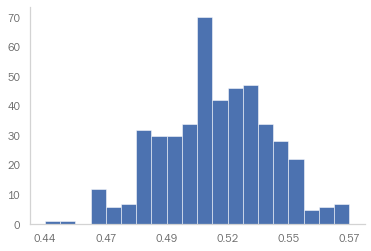

In [35]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

a = results[:, 3].astype(float)

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xticks(np.arange(min(a), max(a)+1, (max(a)-min(a))/5))
ax.hist(a, bins=20, linewidth=0.5, edgecolor="white")
plt.show()


In [38]:
# Using LSTM instead
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

def testAll_lstm(symbols, x1, x3):
    results = list()
    i = 0
    earlyStop=EarlyStopping(monitor="val_accuracy",verbose=2,mode='max',patience=5,restore_best_weights=True)
    for s in symbols:
        i = i + 1
        tickers = [[s],['EURUSD=X', 'JPY=X', 'ZC=F', 'HG=F', 'CL=F', 'GC=F', '^GDAXI', '^FTSE', 'SI=F', '^GSPC', '^DJI']]
#         x1 = marketInformation("10Y", tickers)
        try:
            hist = yf.Ticker(s).history(period="10Y")["Close"]
        except:
            print(f"Cannot get info of {s}, symbol is likely delisted")
            continue
        if hist.shape[0] <= 2500: # Less than 10 years of data
            print(hist.shape[0])
            continue
        hist = np.log(hist / hist.shift(periods=1))
        x1_ = x1.copy()
        x1_[s] = hist
        x2 = technicalInformation("10Y", tickers[0][0])
#         x3 = interestInformation(tickers[0][0])
        x4 = technical2("10Y", tickers[0][0])
        Xp, yp = allFactors(x1_, x2, x3, x4, tickers[0][0])
        if Xp.shape[0] != yp.shape[0] or Xp.shape[0] < 2400:
            print('Poor data')
            x1_ = x1_.drop(columns=[s])
            continue
        Xtrain = Xp[0:1500, :]
        ytrain = yp[0:1500]
        Xp, yp = rfe(Xtrain, ytrain, Xp, yp)
        Xtrain = Xp[0:1500, :]
        ytrain = yp[0:1500]
        Xval = Xp[1500:1900, :]
        yval = yp[1500:1900]
        Xtest = Xp[1900:2400, :]
        ytest = yp[1900:2400]
#         ratio = min(ytrain.mean(), 1-ytrain.mean())/max(ytrain.mean(), 1-ytrain.mean())+0.01
#         if (ratio < 0.9):
#             ros = imblearn.over_sampling.SMOTE(sampling_strategy=min(ratio, 1), random_state=1)
#             Xtrain, ytrain = ros.fit_resample(Xtrain, ytrain)
        
        Xtrain = Xtrain.reshape((Xtrain.shape[0], 1, Xtrain.shape[1]))
        Xval = Xval.reshape((Xval.shape[0], 1, Xval.shape[1]))
        Xtest = Xtest.reshape((Xtest.shape[0], 1, Xtest.shape[1]))
        model = Sequential()
        model.add(LSTM(8, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(Xtrain, ytrain, epochs=20, batch_size=16, validation_data=(Xtest, ytest), verbose=2, shuffle=False, callbacks=[earlyStop])
        pred = (model.predict(Xtest)>0.5)*1
        results.append([s, accuracy((model.predict(Xtrain)>0.5)*1, ytrain), accuracy((model.predict(Xval)>0.5)*1, yval), 
                        accuracy(pred, ytest), 
                        max(np.mean(ytest), 1-np.mean(ytest)), x1_[tickers[0][0]].corr(x1['^GSPC']), pred.mean(), 
                        sklearn.metrics.recall_score(ytest, pred), 
                        sklearn.metrics.precision_score(ytest, pred), 
                        sklearn.metrics.f1_score(ytest, pred)])
        x1_ = x1_.drop(columns=[s])
        if i % 10 == 0:
            print(i)
    return results
    

results = testAll_lstm(symbols, x1, x3)

Epoch 1/20
94/94 - 5s - loss: 0.6940 - accuracy: 0.5233 - val_loss: 0.6914 - val_accuracy: 0.5520 - 5s/epoch - 49ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6875 - accuracy: 0.5327 - val_loss: 0.6920 - val_accuracy: 0.5480 - 321ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6836 - accuracy: 0.5507 - val_loss: 0.6931 - val_accuracy: 0.5280 - 307ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6803 - accuracy: 0.5573 - val_loss: 0.6945 - val_accuracy: 0.5240 - 314ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6774 - accuracy: 0.5733 - val_loss: 0.6962 - val_accuracy: 0.5180 - 318ms/epoch - 3ms/step
Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6747 - accuracy: 0.5760 - val_loss: 0.6980 - val_accuracy: 0.5240 - 326ms/epoch - 3ms/step
Epoch 6: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6957 - accuracy: 0.5133 - val_loss: 0.6956 - val_accuracy: 0.5200 - 2s/epoch - 18ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6884 - accuracy: 0.5440 - va

C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch 1/20
94/94 - 2s - loss: 0.6989 - accuracy: 0.5000 - val_loss: 0.6987 - val_accuracy: 0.4760 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6924 - accuracy: 0.5253 - val_loss: 0.6971 - val_accuracy: 0.4960 - 300ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6886 - accuracy: 0.5560 - val_loss: 0.6976 - val_accuracy: 0.5200 - 294ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6855 - accuracy: 0.5633 - val_loss: 0.6987 - val_accuracy: 0.5100 - 291ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6827 - accuracy: 0.5653 - val_loss: 0.7002 - val_accuracy: 0.5140 - 312ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6799 - accuracy: 0.5700 - val_loss: 0.7022 - val_accuracy: 0.5140 - 312ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6770 - accuracy: 0.5827 - val_loss: 0.7046 - val_accuracy: 0.5180 - 304ms/epoch - 3ms/step
Epoch 8/20
Restoring model weights from the end of the best epoch: 3.
94/94 - 0s - loss: 0.6741 - accuracy: 0.5907 - val_loss: 0.7076 - val_a

Epoch 7/20
94/94 - 0s - loss: 0.6694 - accuracy: 0.5887 - val_loss: 0.7095 - val_accuracy: 0.5280 - 273ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6667 - accuracy: 0.5953 - val_loss: 0.7096 - val_accuracy: 0.5280 - 271ms/epoch - 3ms/step
Epoch 9/20
94/94 - 0s - loss: 0.6639 - accuracy: 0.5973 - val_loss: 0.7096 - val_accuracy: 0.5280 - 272ms/epoch - 3ms/step
Epoch 10/20
94/94 - 0s - loss: 0.6610 - accuracy: 0.6027 - val_loss: 0.7094 - val_accuracy: 0.5400 - 277ms/epoch - 3ms/step
Epoch 11/20
94/94 - 0s - loss: 0.6581 - accuracy: 0.6127 - val_loss: 0.7092 - val_accuracy: 0.5340 - 262ms/epoch - 3ms/step
Epoch 12/20
94/94 - 0s - loss: 0.6552 - accuracy: 0.6167 - val_loss: 0.7096 - val_accuracy: 0.5440 - 270ms/epoch - 3ms/step
Epoch 13/20
94/94 - 0s - loss: 0.6522 - accuracy: 0.6180 - val_loss: 0.7106 - val_accuracy: 0.5460 - 284ms/epoch - 3ms/step
Epoch 14/20
94/94 - 0s - loss: 0.6491 - accuracy: 0.6200 - val_loss: 0.7123 - val_accuracy: 0.5420 - 298ms/epoch - 3ms/step
Epoch 15/20

Epoch 6/20
94/94 - 0s - loss: 0.6751 - accuracy: 0.5793 - val_loss: 0.6890 - val_accuracy: 0.5320 - 294ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6715 - accuracy: 0.5987 - val_loss: 0.6889 - val_accuracy: 0.5360 - 288ms/epoch - 3ms/step
Epoch 8/20
Restoring model weights from the end of the best epoch: 3.
94/94 - 0s - loss: 0.6679 - accuracy: 0.6053 - val_loss: 0.6891 - val_accuracy: 0.5300 - 292ms/epoch - 3ms/step
Epoch 8: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6952 - accuracy: 0.5113 - val_loss: 0.6999 - val_accuracy: 0.4940 - 2s/epoch - 19ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6904 - accuracy: 0.5340 - val_loss: 0.6999 - val_accuracy: 0.5060 - 305ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6872 - accuracy: 0.5547 - val_loss: 0.7006 - val_accuracy: 0.5000 - 305ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6844 - accuracy: 0.5627 - val_loss: 0.7016 - val_accuracy: 0.4980 - 308ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6818 - accuracy: 0.5640 - 

Epoch 5/20
94/94 - 0s - loss: 0.6770 - accuracy: 0.5747 - val_loss: 0.7089 - val_accuracy: 0.5260 - 316ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6739 - accuracy: 0.5793 - val_loss: 0.7094 - val_accuracy: 0.5380 - 289ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6710 - accuracy: 0.5900 - val_loss: 0.7106 - val_accuracy: 0.5340 - 304ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6680 - accuracy: 0.5920 - val_loss: 0.7124 - val_accuracy: 0.5260 - 314ms/epoch - 3ms/step
Epoch 9/20
94/94 - 0s - loss: 0.6651 - accuracy: 0.6007 - val_loss: 0.7143 - val_accuracy: 0.5280 - 310ms/epoch - 3ms/step
Epoch 10/20
94/94 - 0s - loss: 0.6621 - accuracy: 0.6093 - val_loss: 0.7164 - val_accuracy: 0.5240 - 302ms/epoch - 3ms/step
Epoch 11/20
Restoring model weights from the end of the best epoch: 6.
94/94 - 0s - loss: 0.6590 - accuracy: 0.6153 - val_loss: 0.7189 - val_accuracy: 0.5140 - 319ms/epoch - 3ms/step
Epoch 11: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.7009 - accuracy: 0.52

C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Poor data


C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch 1/20
94/94 - 2s - loss: 0.7024 - accuracy: 0.4660 - val_loss: 0.7290 - val_accuracy: 0.4720 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6954 - accuracy: 0.5053 - val_loss: 0.7311 - val_accuracy: 0.4740 - 286ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6926 - accuracy: 0.5187 - val_loss: 0.7186 - val_accuracy: 0.4760 - 277ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6903 - accuracy: 0.5267 - val_loss: 0.7082 - val_accuracy: 0.4980 - 285ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6883 - accuracy: 0.5293 - val_loss: 0.7042 - val_accuracy: 0.5040 - 281ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6863 - accuracy: 0.5407 - val_loss: 0.7008 - val_accuracy: 0.4840 - 282ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6845 - accuracy: 0.5460 - val_loss: 0.6981 - val_accuracy: 0.5140 - 276ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6826 - accuracy: 0.5533 - val_loss: 0.6979 - val_accuracy: 0.5140 - 293ms/epoch - 3ms/step
Epoch 9/20
94/94 -

Epoch 8/20
Restoring model weights from the end of the best epoch: 3.
94/94 - 0s - loss: 0.6689 - accuracy: 0.5953 - val_loss: 0.7015 - val_accuracy: 0.4940 - 282ms/epoch - 3ms/step
Epoch 8: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6951 - accuracy: 0.5033 - val_loss: 0.6901 - val_accuracy: 0.5480 - 2s/epoch - 22ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6871 - accuracy: 0.5440 - val_loss: 0.6933 - val_accuracy: 0.5420 - 282ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6826 - accuracy: 0.5567 - val_loss: 0.6966 - val_accuracy: 0.5400 - 306ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6790 - accuracy: 0.5673 - val_loss: 0.6998 - val_accuracy: 0.5480 - 292ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6757 - accuracy: 0.5807 - val_loss: 0.7027 - val_accuracy: 0.5480 - 281ms/epoch - 3ms/step
Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6724 - accuracy: 0.5927 - val_loss: 0.7062 - val_accuracy: 0.5460 - 283ms/epoch - 3ms/step

Epoch 4/20
94/94 - 0s - loss: 0.6757 - accuracy: 0.5720 - val_loss: 0.7100 - val_accuracy: 0.4760 - 277ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6716 - accuracy: 0.5833 - val_loss: 0.7148 - val_accuracy: 0.4880 - 291ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6678 - accuracy: 0.5907 - val_loss: 0.7197 - val_accuracy: 0.4860 - 288ms/epoch - 3ms/step
Epoch 7/20
Restoring model weights from the end of the best epoch: 2.
94/94 - 0s - loss: 0.6641 - accuracy: 0.6000 - val_loss: 0.7246 - val_accuracy: 0.4820 - 287ms/epoch - 3ms/step
Epoch 7: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6976 - accuracy: 0.5140 - val_loss: 0.7102 - val_accuracy: 0.4940 - 2s/epoch - 22ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6904 - accuracy: 0.5360 - val_loss: 0.7008 - val_accuracy: 0.4820 - 310ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6870 - accuracy: 0.5540 - val_loss: 0.7004 - val_accuracy: 0.5140 - 311ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6845 - accuracy: 0.5600 - 

Epoch 8/20
94/94 - 0s - loss: 0.6714 - accuracy: 0.5787 - val_loss: 0.7071 - val_accuracy: 0.5160 - 295ms/epoch - 3ms/step
Epoch 9/20
94/94 - 0s - loss: 0.6692 - accuracy: 0.5780 - val_loss: 0.7098 - val_accuracy: 0.5180 - 295ms/epoch - 3ms/step
Epoch 10/20
94/94 - 0s - loss: 0.6670 - accuracy: 0.5860 - val_loss: 0.7127 - val_accuracy: 0.5100 - 299ms/epoch - 3ms/step
Epoch 11/20
94/94 - 0s - loss: 0.6647 - accuracy: 0.5927 - val_loss: 0.7158 - val_accuracy: 0.5080 - 302ms/epoch - 3ms/step
Epoch 12/20
Restoring model weights from the end of the best epoch: 7.
94/94 - 0s - loss: 0.6624 - accuracy: 0.5953 - val_loss: 0.7190 - val_accuracy: 0.5000 - 316ms/epoch - 3ms/step
Epoch 12: early stopping
1990
Epoch 1/20
94/94 - 2s - loss: 0.7002 - accuracy: 0.5107 - val_loss: 0.6942 - val_accuracy: 0.4980 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6923 - accuracy: 0.5340 - val_loss: 0.6920 - val_accuracy: 0.5120 - 323ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6883 - accuracy: 

Epoch 18/20
94/94 - 0s - loss: 0.6425 - accuracy: 0.6307 - val_loss: 0.7413 - val_accuracy: 0.4840 - 274ms/epoch - 3ms/step
Epoch 19/20
94/94 - 0s - loss: 0.6396 - accuracy: 0.6307 - val_loss: 0.7445 - val_accuracy: 0.4900 - 279ms/epoch - 3ms/step
Epoch 20/20
94/94 - 0s - loss: 0.6367 - accuracy: 0.6353 - val_loss: 0.7480 - val_accuracy: 0.4900 - 294ms/epoch - 3ms/step
Epoch 1/20
94/94 - 2s - loss: 0.6997 - accuracy: 0.4947 - val_loss: 0.7062 - val_accuracy: 0.5100 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6912 - accuracy: 0.5307 - val_loss: 0.7038 - val_accuracy: 0.5120 - 302ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6864 - accuracy: 0.5527 - val_loss: 0.7041 - val_accuracy: 0.5100 - 309ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6824 - accuracy: 0.5653 - val_loss: 0.7064 - val_accuracy: 0.5100 - 295ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6788 - accuracy: 0.5787 - val_loss: 0.7096 - val_accuracy: 0.5160 - 322ms/epoch - 3ms/step
Epoch 6/20
94/9

C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch 1/20
94/94 - 2s - loss: 0.6938 - accuracy: 0.5253 - val_loss: 0.6974 - val_accuracy: 0.5120 - 2s/epoch - 22ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6882 - accuracy: 0.5347 - val_loss: 0.6954 - val_accuracy: 0.5240 - 317ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6842 - accuracy: 0.5393 - val_loss: 0.6946 - val_accuracy: 0.5260 - 298ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6806 - accuracy: 0.5613 - val_loss: 0.6942 - val_accuracy: 0.5200 - 317ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6772 - accuracy: 0.5747 - val_loss: 0.6939 - val_accuracy: 0.5180 - 308ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6739 - accuracy: 0.5767 - val_loss: 0.6939 - val_accuracy: 0.5280 - 315ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6705 - accuracy: 0.5853 - val_loss: 0.6942 - val_accuracy: 0.5200 - 306ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6672 - accuracy: 0.5927 - val_loss: 0.6946 - val_accuracy: 0.5160 - 296ms/epoch - 3ms/step
Epoch 9/20
94/94 -

Epoch 5/20
94/94 - 0s - loss: 0.6781 - accuracy: 0.5860 - val_loss: 0.6954 - val_accuracy: 0.5480 - 304ms/epoch - 3ms/step
Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6752 - accuracy: 0.5913 - val_loss: 0.6933 - val_accuracy: 0.5520 - 312ms/epoch - 3ms/step
Epoch 6: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6945 - accuracy: 0.5093 - val_loss: 0.7212 - val_accuracy: 0.4880 - 2s/epoch - 19ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6898 - accuracy: 0.5293 - val_loss: 0.7237 - val_accuracy: 0.4840 - 305ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6866 - accuracy: 0.5447 - val_loss: 0.7257 - val_accuracy: 0.4820 - 301ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6835 - accuracy: 0.5540 - val_loss: 0.7279 - val_accuracy: 0.4720 - 288ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6804 - accuracy: 0.5587 - val_loss: 0.7304 - val_accuracy: 0.4660 - 305ms/epoch - 3ms/step
Epoch 6/20
Restoring model weights from the end of the bes

Epoch 4/20
94/94 - 0s - loss: 0.6798 - accuracy: 0.5680 - val_loss: 0.6958 - val_accuracy: 0.5260 - 286ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6773 - accuracy: 0.5760 - val_loss: 0.6949 - val_accuracy: 0.5000 - 321ms/epoch - 3ms/step
Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6748 - accuracy: 0.5880 - val_loss: 0.6946 - val_accuracy: 0.5060 - 305ms/epoch - 3ms/step
Epoch 6: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6925 - accuracy: 0.5213 - val_loss: 0.7018 - val_accuracy: 0.5020 - 2s/epoch - 20ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6872 - accuracy: 0.5473 - val_loss: 0.7107 - val_accuracy: 0.5000 - 299ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6846 - accuracy: 0.5487 - val_loss: 0.7173 - val_accuracy: 0.4940 - 294ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6824 - accuracy: 0.5533 - val_loss: 0.7220 - val_accuracy: 0.4960 - 314ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6804 - accuracy: 0.5613 - 

Epoch 9: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.7038 - accuracy: 0.4773 - val_loss: 0.7732 - val_accuracy: 0.4560 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6947 - accuracy: 0.5153 - val_loss: 0.7696 - val_accuracy: 0.4480 - 254ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6905 - accuracy: 0.5307 - val_loss: 0.7670 - val_accuracy: 0.4400 - 285ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6873 - accuracy: 0.5420 - val_loss: 0.7652 - val_accuracy: 0.4340 - 268ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6845 - accuracy: 0.5607 - val_loss: 0.7637 - val_accuracy: 0.4380 - 283ms/epoch - 3ms/step
Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6819 - accuracy: 0.5713 - val_loss: 0.7618 - val_accuracy: 0.4460 - 260ms/epoch - 3ms/step
Epoch 6: early stopping
80
- BF.B: No data found for this date range, symbol may be delisted
0
Epoch 1/20
94/94 - 2s - loss: 0.6949 - accuracy: 0.5073 - val_loss: 0.7089 - val_accur

Epoch 6/20
94/94 - 0s - loss: 0.6752 - accuracy: 0.5807 - val_loss: 0.7038 - val_accuracy: 0.5120 - 319ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6725 - accuracy: 0.5960 - val_loss: 0.7039 - val_accuracy: 0.5180 - 308ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6699 - accuracy: 0.6013 - val_loss: 0.7039 - val_accuracy: 0.5120 - 303ms/epoch - 3ms/step
Epoch 9/20
94/94 - 0s - loss: 0.6674 - accuracy: 0.6000 - val_loss: 0.7038 - val_accuracy: 0.5200 - 288ms/epoch - 3ms/step
Epoch 10/20
94/94 - 0s - loss: 0.6648 - accuracy: 0.6027 - val_loss: 0.7039 - val_accuracy: 0.5240 - 300ms/epoch - 3ms/step
Epoch 11/20
94/94 - 0s - loss: 0.6623 - accuracy: 0.6073 - val_loss: 0.7041 - val_accuracy: 0.5280 - 284ms/epoch - 3ms/step
Epoch 12/20
94/94 - 0s - loss: 0.6599 - accuracy: 0.6133 - val_loss: 0.7045 - val_accuracy: 0.5320 - 323ms/epoch - 3ms/step
Epoch 13/20
94/94 - 0s - loss: 0.6575 - accuracy: 0.6187 - val_loss: 0.7049 - val_accuracy: 0.5280 - 288ms/epoch - 3ms/step
Epoch 14/20


C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch 1/20
94/94 - 2s - loss: 0.6923 - accuracy: 0.5180 - val_loss: 0.7018 - val_accuracy: 0.4980 - 2s/epoch - 18ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6867 - accuracy: 0.5420 - val_loss: 0.7029 - val_accuracy: 0.4780 - 316ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6832 - accuracy: 0.5520 - val_loss: 0.7044 - val_accuracy: 0.4820 - 287ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6801 - accuracy: 0.5627 - val_loss: 0.7060 - val_accuracy: 0.4820 - 297ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6770 - accuracy: 0.5727 - val_loss: 0.7078 - val_accuracy: 0.4880 - 312ms/epoch - 3ms/step
Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6739 - accuracy: 0.5833 - val_loss: 0.7099 - val_accuracy: 0.4880 - 291ms/epoch - 3ms/step
Epoch 6: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.7000 - accuracy: 0.4953 - val_loss: 0.7180 - val_accuracy: 0.4700 - 2s/epoch - 22ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6942 - accuracy: 0.5113 - va

Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6767 - accuracy: 0.5747 - val_loss: 0.7009 - val_accuracy: 0.4920 - 314ms/epoch - 3ms/step
Epoch 6: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6966 - accuracy: 0.5147 - val_loss: 0.7134 - val_accuracy: 0.4520 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6904 - accuracy: 0.5380 - val_loss: 0.7076 - val_accuracy: 0.4620 - 315ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6873 - accuracy: 0.5533 - val_loss: 0.7068 - val_accuracy: 0.4860 - 289ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6846 - accuracy: 0.5607 - val_loss: 0.7069 - val_accuracy: 0.4940 - 301ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6821 - accuracy: 0.5640 - val_loss: 0.7075 - val_accuracy: 0.4940 - 282ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6796 - accuracy: 0.5733 - val_loss: 0.7088 - val_accuracy: 0.4880 - 301ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6770 - accuracy: 0.5820 - 

C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch 1/20
94/94 - 2s - loss: 0.6956 - accuracy: 0.5087 - val_loss: 0.7119 - val_accuracy: 0.4620 - 2s/epoch - 18ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6883 - accuracy: 0.5333 - val_loss: 0.7096 - val_accuracy: 0.4500 - 286ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6837 - accuracy: 0.5473 - val_loss: 0.7091 - val_accuracy: 0.4640 - 288ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6798 - accuracy: 0.5620 - val_loss: 0.7084 - val_accuracy: 0.4760 - 299ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6761 - accuracy: 0.5660 - val_loss: 0.7077 - val_accuracy: 0.4760 - 284ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6724 - accuracy: 0.5773 - val_loss: 0.7087 - val_accuracy: 0.4760 - 277ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6687 - accuracy: 0.5893 - val_loss: 0.7111 - val_accuracy: 0.4740 - 293ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6650 - accuracy: 0.5940 - val_loss: 0.7141 - val_accuracy: 0.4800 - 274ms/epoch - 3ms/step
Epoch 9/20
94/94 -

Epoch 3/20
94/94 - 0s - loss: 0.6845 - accuracy: 0.5540 - val_loss: 0.7035 - val_accuracy: 0.5160 - 314ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6806 - accuracy: 0.5740 - val_loss: 0.7074 - val_accuracy: 0.5120 - 310ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6771 - accuracy: 0.5827 - val_loss: 0.7103 - val_accuracy: 0.5120 - 274ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6739 - accuracy: 0.5940 - val_loss: 0.7130 - val_accuracy: 0.5200 - 328ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6709 - accuracy: 0.6060 - val_loss: 0.7158 - val_accuracy: 0.5180 - 293ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6682 - accuracy: 0.6100 - val_loss: 0.7184 - val_accuracy: 0.5260 - 295ms/epoch - 3ms/step
Epoch 9/20
94/94 - 0s - loss: 0.6655 - accuracy: 0.6120 - val_loss: 0.7207 - val_accuracy: 0.5300 - 280ms/epoch - 3ms/step
Epoch 10/20
94/94 - 0s - loss: 0.6629 - accuracy: 0.6147 - val_loss: 0.7224 - val_accuracy: 0.5300 - 294ms/epoch - 3ms/step
Epoch 11/20
94/

Epoch 3/20
94/94 - 0s - loss: 0.6829 - accuracy: 0.5627 - val_loss: 0.7093 - val_accuracy: 0.5020 - 305ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6785 - accuracy: 0.5720 - val_loss: 0.7116 - val_accuracy: 0.5080 - 315ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6747 - accuracy: 0.5807 - val_loss: 0.7142 - val_accuracy: 0.5040 - 313ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6711 - accuracy: 0.5873 - val_loss: 0.7172 - val_accuracy: 0.5100 - 300ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6676 - accuracy: 0.6007 - val_loss: 0.7208 - val_accuracy: 0.5120 - 310ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6641 - accuracy: 0.6060 - val_loss: 0.7249 - val_accuracy: 0.5140 - 288ms/epoch - 3ms/step
Epoch 9/20
94/94 - 0s - loss: 0.6605 - accuracy: 0.6153 - val_loss: 0.7294 - val_accuracy: 0.5120 - 289ms/epoch - 3ms/step
Epoch 10/20
94/94 - 0s - loss: 0.6569 - accuracy: 0.6287 - val_loss: 0.7342 - val_accuracy: 0.5080 - 311ms/epoch - 3ms/step
Epoch 11/20
94/

Epoch 4/20
94/94 - 0s - loss: 0.6829 - accuracy: 0.5787 - val_loss: 0.6956 - val_accuracy: 0.5100 - 300ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6800 - accuracy: 0.5853 - val_loss: 0.6967 - val_accuracy: 0.5180 - 315ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6771 - accuracy: 0.5893 - val_loss: 0.6987 - val_accuracy: 0.5260 - 303ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6741 - accuracy: 0.5947 - val_loss: 0.7019 - val_accuracy: 0.5300 - 328ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6711 - accuracy: 0.5987 - val_loss: 0.7070 - val_accuracy: 0.5360 - 293ms/epoch - 3ms/step
Epoch 9/20
94/94 - 0s - loss: 0.6681 - accuracy: 0.6067 - val_loss: 0.7135 - val_accuracy: 0.5360 - 308ms/epoch - 3ms/step
Epoch 10/20
94/94 - 0s - loss: 0.6650 - accuracy: 0.6140 - val_loss: 0.7205 - val_accuracy: 0.5420 - 287ms/epoch - 3ms/step
Epoch 11/20
94/94 - 0s - loss: 0.6619 - accuracy: 0.6207 - val_loss: 0.7283 - val_accuracy: 0.5340 - 301ms/epoch - 3ms/step
Epoch 12/20
94

Epoch 7: early stopping


C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch 1/20
94/94 - 2s - loss: 0.6938 - accuracy: 0.5373 - val_loss: 0.7270 - val_accuracy: 0.4840 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6885 - accuracy: 0.5393 - val_loss: 0.7193 - val_accuracy: 0.4940 - 299ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6848 - accuracy: 0.5527 - val_loss: 0.7152 - val_accuracy: 0.5020 - 297ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6815 - accuracy: 0.5567 - val_loss: 0.7130 - val_accuracy: 0.4900 - 313ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6785 - accuracy: 0.5640 - val_loss: 0.7121 - val_accuracy: 0.4920 - 274ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6757 - accuracy: 0.5707 - val_loss: 0.7122 - val_accuracy: 0.4940 - 285ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6729 - accuracy: 0.5753 - val_loss: 0.7131 - val_accuracy: 0.4980 - 312ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6701 - accuracy: 0.5773 - val_loss: 0.7149 - val_accuracy: 0.5060 - 286ms/epoch - 3ms/step
Epoch 9/20
94/94 -

94/94 - 0s - loss: 0.6555 - accuracy: 0.6280 - val_loss: 0.7833 - val_accuracy: 0.5200 - 323ms/epoch - 3ms/step
Epoch 14: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.7029 - accuracy: 0.5140 - val_loss: 0.7146 - val_accuracy: 0.5380 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6907 - accuracy: 0.5513 - val_loss: 0.7026 - val_accuracy: 0.5480 - 310ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6859 - accuracy: 0.5673 - val_loss: 0.7020 - val_accuracy: 0.5120 - 290ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6825 - accuracy: 0.5647 - val_loss: 0.7028 - val_accuracy: 0.5020 - 282ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6795 - accuracy: 0.5767 - val_loss: 0.7033 - val_accuracy: 0.4960 - 299ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6767 - accuracy: 0.5800 - val_loss: 0.7036 - val_accuracy: 0.4980 - 312ms/epoch - 3ms/step
Epoch 7/20
Restoring model weights from the end of the best epoch: 2.
94/94 - 0s - loss: 0.6740 - accuracy: 0.5853 - val_loss: 

C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch 1/20
94/94 - 2s - loss: 0.6981 - accuracy: 0.4767 - val_loss: 0.7054 - val_accuracy: 0.5440 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6937 - accuracy: 0.4980 - val_loss: 0.7052 - val_accuracy: 0.5420 - 308ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6906 - accuracy: 0.5147 - val_loss: 0.7048 - val_accuracy: 0.5280 - 328ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6879 - accuracy: 0.5373 - val_loss: 0.7034 - val_accuracy: 0.5200 - 301ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6854 - accuracy: 0.5507 - val_loss: 0.7019 - val_accuracy: 0.5080 - 304ms/epoch - 3ms/step
Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6830 - accuracy: 0.5667 - val_loss: 0.7008 - val_accuracy: 0.5000 - 325ms/epoch - 3ms/step
Epoch 6: early stopping
2402
Epoch 1/20
94/94 - 2s - loss: 0.6994 - accuracy: 0.5093 - val_loss: 0.7020 - val_accuracy: 0.5100 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6896 - accuracy: 0.5440

Epoch 6/20
94/94 - 0s - loss: 0.6801 - accuracy: 0.5653 - val_loss: 0.7120 - val_accuracy: 0.5260 - 277ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6772 - accuracy: 0.5687 - val_loss: 0.7163 - val_accuracy: 0.5180 - 303ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6744 - accuracy: 0.5687 - val_loss: 0.7210 - val_accuracy: 0.5240 - 306ms/epoch - 3ms/step
Epoch 9/20
94/94 - 0s - loss: 0.6716 - accuracy: 0.5720 - val_loss: 0.7260 - val_accuracy: 0.5260 - 299ms/epoch - 3ms/step
Epoch 10/20
Restoring model weights from the end of the best epoch: 5.
94/94 - 0s - loss: 0.6689 - accuracy: 0.5833 - val_loss: 0.7309 - val_accuracy: 0.5260 - 281ms/epoch - 3ms/step
Epoch 10: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6889 - accuracy: 0.5300 - val_loss: 0.7147 - val_accuracy: 0.5240 - 2s/epoch - 18ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6800 - accuracy: 0.5580 - val_loss: 0.7196 - val_accuracy: 0.5220 - 300ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6756 - accuracy: 0.5787 

Epoch 4/20
94/94 - 0s - loss: 0.6846 - accuracy: 0.5393 - val_loss: 0.7036 - val_accuracy: 0.4960 - 313ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6828 - accuracy: 0.5393 - val_loss: 0.7044 - val_accuracy: 0.5100 - 302ms/epoch - 3ms/step
Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6811 - accuracy: 0.5493 - val_loss: 0.7052 - val_accuracy: 0.4960 - 313ms/epoch - 3ms/step
Epoch 6: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6966 - accuracy: 0.5207 - val_loss: 0.7143 - val_accuracy: 0.4440 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6892 - accuracy: 0.5393 - val_loss: 0.7132 - val_accuracy: 0.4560 - 298ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6844 - accuracy: 0.5620 - val_loss: 0.7147 - val_accuracy: 0.4560 - 312ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6806 - accuracy: 0.5673 - val_loss: 0.7176 - val_accuracy: 0.4620 - 315ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6772 - accuracy: 0.5700 - 

Epoch 9/20
Restoring model weights from the end of the best epoch: 4.
94/94 - 0s - loss: 0.6693 - accuracy: 0.5880 - val_loss: 0.7199 - val_accuracy: 0.5180 - 314ms/epoch - 3ms/step
Epoch 9: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6999 - accuracy: 0.5020 - val_loss: 0.7080 - val_accuracy: 0.4720 - 2s/epoch - 18ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6933 - accuracy: 0.5260 - val_loss: 0.7014 - val_accuracy: 0.4580 - 286ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6894 - accuracy: 0.5407 - val_loss: 0.7005 - val_accuracy: 0.5000 - 306ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6863 - accuracy: 0.5540 - val_loss: 0.7011 - val_accuracy: 0.4920 - 297ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6836 - accuracy: 0.5560 - val_loss: 0.7019 - val_accuracy: 0.4900 - 291ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6811 - accuracy: 0.5700 - val_loss: 0.7025 - val_accuracy: 0.5060 - 293ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6786 - accuracy: 0.5753 - 

Epoch 4/20
94/94 - 0s - loss: 0.6800 - accuracy: 0.5913 - val_loss: 0.7380 - val_accuracy: 0.4960 - 313ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6774 - accuracy: 0.5940 - val_loss: 0.7406 - val_accuracy: 0.5020 - 313ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6748 - accuracy: 0.5947 - val_loss: 0.7425 - val_accuracy: 0.4920 - 282ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6724 - accuracy: 0.5900 - val_loss: 0.7439 - val_accuracy: 0.4980 - 306ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6700 - accuracy: 0.5887 - val_loss: 0.7450 - val_accuracy: 0.4980 - 304ms/epoch - 3ms/step
Epoch 9/20
94/94 - 0s - loss: 0.6678 - accuracy: 0.5933 - val_loss: 0.7462 - val_accuracy: 0.5000 - 287ms/epoch - 3ms/step
Epoch 10/20
94/94 - 0s - loss: 0.6656 - accuracy: 0.6007 - val_loss: 0.7473 - val_accuracy: 0.5040 - 304ms/epoch - 3ms/step
Epoch 11/20
94/94 - 0s - loss: 0.6635 - accuracy: 0.6047 - val_loss: 0.7486 - val_accuracy: 0.5060 - 296ms/epoch - 3ms/step
Epoch 12/20
94

Epoch 16/20
Restoring model weights from the end of the best epoch: 11.
94/94 - 0s - loss: 0.6468 - accuracy: 0.6307 - val_loss: 0.7415 - val_accuracy: 0.5160 - 281ms/epoch - 3ms/step
Epoch 16: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.7067 - accuracy: 0.4853 - val_loss: 0.7157 - val_accuracy: 0.4820 - 2s/epoch - 18ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6954 - accuracy: 0.5207 - val_loss: 0.7105 - val_accuracy: 0.5080 - 265ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6888 - accuracy: 0.5300 - val_loss: 0.7080 - val_accuracy: 0.4960 - 284ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6838 - accuracy: 0.5453 - val_loss: 0.7059 - val_accuracy: 0.5000 - 294ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6796 - accuracy: 0.5593 - val_loss: 0.7037 - val_accuracy: 0.4940 - 274ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6757 - accuracy: 0.5767 - val_loss: 0.7022 - val_accuracy: 0.4840 - 276ms/epoch - 3ms/step
Epoch 7/20
Restoring model weights from the end of the 

Epoch 13: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6979 - accuracy: 0.4900 - val_loss: 0.6909 - val_accuracy: 0.5320 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6922 - accuracy: 0.5067 - val_loss: 0.6940 - val_accuracy: 0.4920 - 275ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6890 - accuracy: 0.5120 - val_loss: 0.6985 - val_accuracy: 0.4800 - 288ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6862 - accuracy: 0.5293 - val_loss: 0.7029 - val_accuracy: 0.4680 - 286ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6835 - accuracy: 0.5487 - val_loss: 0.7068 - val_accuracy: 0.4780 - 318ms/epoch - 3ms/step
Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6808 - accuracy: 0.5693 - val_loss: 0.7102 - val_accuracy: 0.4840 - 313ms/epoch - 3ms/step
Epoch 6: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6973 - accuracy: 0.4933 - val_loss: 0.7147 - val_accuracy: 0.4500 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.690

Epoch 8/20
Restoring model weights from the end of the best epoch: 3.
94/94 - 0s - loss: 0.6695 - accuracy: 0.6073 - val_loss: 0.7077 - val_accuracy: 0.5360 - 293ms/epoch - 3ms/step
Epoch 8: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.7015 - accuracy: 0.5087 - val_loss: 0.6885 - val_accuracy: 0.5300 - 2s/epoch - 20ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6915 - accuracy: 0.5227 - val_loss: 0.6882 - val_accuracy: 0.5200 - 274ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6867 - accuracy: 0.5367 - val_loss: 0.6879 - val_accuracy: 0.5260 - 298ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6830 - accuracy: 0.5507 - val_loss: 0.6881 - val_accuracy: 0.5360 - 293ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6800 - accuracy: 0.5593 - val_loss: 0.6887 - val_accuracy: 0.5320 - 286ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6772 - accuracy: 0.5720 - val_loss: 0.6895 - val_accuracy: 0.5360 - 309ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6745 - accuracy: 0.5793 - 

Epoch 17/20
94/94 - 0s - loss: 0.6371 - accuracy: 0.6467 - val_loss: 0.7167 - val_accuracy: 0.5180 - 290ms/epoch - 3ms/step
Epoch 18/20
94/94 - 0s - loss: 0.6336 - accuracy: 0.6467 - val_loss: 0.7173 - val_accuracy: 0.5140 - 328ms/epoch - 3ms/step
Epoch 19/20
Restoring model weights from the end of the best epoch: 14.
94/94 - 0s - loss: 0.6300 - accuracy: 0.6447 - val_loss: 0.7181 - val_accuracy: 0.5100 - 308ms/epoch - 3ms/step
Epoch 19: early stopping
792
791
Epoch 1/20
94/94 - 2s - loss: 0.6939 - accuracy: 0.5373 - val_loss: 0.6946 - val_accuracy: 0.5020 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6883 - accuracy: 0.5607 - val_loss: 0.6945 - val_accuracy: 0.5100 - 290ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6843 - accuracy: 0.5633 - val_loss: 0.6956 - val_accuracy: 0.5060 - 301ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6807 - accuracy: 0.5727 - val_loss: 0.6967 - val_accuracy: 0.5060 - 309ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6773 - accura

Epoch 3/20
94/94 - 0s - loss: 0.6854 - accuracy: 0.5600 - val_loss: 0.7004 - val_accuracy: 0.4860 - 301ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6816 - accuracy: 0.5660 - val_loss: 0.6984 - val_accuracy: 0.5260 - 301ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6779 - accuracy: 0.5807 - val_loss: 0.6973 - val_accuracy: 0.5300 - 273ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6742 - accuracy: 0.5880 - val_loss: 0.6959 - val_accuracy: 0.5440 - 280ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6705 - accuracy: 0.5880 - val_loss: 0.6947 - val_accuracy: 0.5340 - 286ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6669 - accuracy: 0.5933 - val_loss: 0.6936 - val_accuracy: 0.5300 - 262ms/epoch - 3ms/step
Epoch 9/20
94/94 - 0s - loss: 0.6633 - accuracy: 0.6000 - val_loss: 0.6928 - val_accuracy: 0.5300 - 286ms/epoch - 3ms/step
Epoch 10/20
94/94 - 0s - loss: 0.6599 - accuracy: 0.6053 - val_loss: 0.6929 - val_accuracy: 0.5220 - 257ms/epoch - 3ms/step
Epoch 11/20
Res

Epoch 10: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.7086 - accuracy: 0.4787 - val_loss: 0.7189 - val_accuracy: 0.5020 - 2s/epoch - 18ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6916 - accuracy: 0.5267 - val_loss: 0.7151 - val_accuracy: 0.5000 - 279ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6849 - accuracy: 0.5400 - val_loss: 0.7196 - val_accuracy: 0.4940 - 279ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6806 - accuracy: 0.5507 - val_loss: 0.7240 - val_accuracy: 0.4880 - 286ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6769 - accuracy: 0.5620 - val_loss: 0.7288 - val_accuracy: 0.4960 - 291ms/epoch - 3ms/step
Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6737 - accuracy: 0.5733 - val_loss: 0.7338 - val_accuracy: 0.4820 - 287ms/epoch - 3ms/step
Epoch 6: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6951 - accuracy: 0.4967 - val_loss: 0.7219 - val_accuracy: 0.4520 - 2s/epoch - 20ms/step
Epoch 2/20
94/94 - 0s - loss: 0.689

C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch 1/20
94/94 - 2s - loss: 0.6928 - accuracy: 0.5253 - val_loss: 0.6967 - val_accuracy: 0.5040 - 2s/epoch - 20ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6865 - accuracy: 0.5553 - val_loss: 0.6957 - val_accuracy: 0.5060 - 278ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6827 - accuracy: 0.5600 - val_loss: 0.6957 - val_accuracy: 0.5000 - 282ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6797 - accuracy: 0.5667 - val_loss: 0.6960 - val_accuracy: 0.5040 - 262ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6771 - accuracy: 0.5760 - val_loss: 0.6964 - val_accuracy: 0.5080 - 281ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6747 - accuracy: 0.5773 - val_loss: 0.6968 - val_accuracy: 0.5100 - 256ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6723 - accuracy: 0.5840 - val_loss: 0.6972 - val_accuracy: 0.5200 - 269ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6701 - accuracy: 0.5960 - val_loss: 0.6977 - val_accuracy: 0.5180 - 258ms/epoch - 3ms/step
Epoch 9/20
94/94 -

94/94 - 0s - loss: 0.6618 - accuracy: 0.5987 - val_loss: 0.7243 - val_accuracy: 0.5200 - 295ms/epoch - 3ms/step
Epoch 14: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.7003 - accuracy: 0.4920 - val_loss: 0.7159 - val_accuracy: 0.5340 - 2s/epoch - 18ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6916 - accuracy: 0.5280 - val_loss: 0.7102 - val_accuracy: 0.5140 - 301ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6869 - accuracy: 0.5547 - val_loss: 0.7072 - val_accuracy: 0.5060 - 300ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6835 - accuracy: 0.5600 - val_loss: 0.7055 - val_accuracy: 0.5120 - 287ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6807 - accuracy: 0.5593 - val_loss: 0.7047 - val_accuracy: 0.5180 - 284ms/epoch - 3ms/step
Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6779 - accuracy: 0.5727 - val_loss: 0.7043 - val_accuracy: 0.5160 - 311ms/epoch - 3ms/step
Epoch 6: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.7017 - accur

Epoch 2/20
94/94 - 0s - loss: 0.6836 - accuracy: 0.5620 - val_loss: 0.6908 - val_accuracy: 0.5740 - 286ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6801 - accuracy: 0.5673 - val_loss: 0.6990 - val_accuracy: 0.5720 - 300ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6771 - accuracy: 0.5740 - val_loss: 0.7086 - val_accuracy: 0.5720 - 287ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6744 - accuracy: 0.5800 - val_loss: 0.7168 - val_accuracy: 0.5680 - 310ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6716 - accuracy: 0.5873 - val_loss: 0.7232 - val_accuracy: 0.5700 - 313ms/epoch - 3ms/step
Epoch 7/20
Restoring model weights from the end of the best epoch: 2.
94/94 - 0s - loss: 0.6688 - accuracy: 0.5933 - val_loss: 0.7276 - val_accuracy: 0.5700 - 303ms/epoch - 3ms/step
Epoch 7: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.7026 - accuracy: 0.4940 - val_loss: 0.6882 - val_accuracy: 0.5340 - 2s/epoch - 18ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6905 - accuracy: 0.5493 - 

Epoch 11/20
94/94 - 0s - loss: 0.6726 - accuracy: 0.5840 - val_loss: 0.7014 - val_accuracy: 0.5280 - 316ms/epoch - 3ms/step
Epoch 12/20
94/94 - 0s - loss: 0.6699 - accuracy: 0.5887 - val_loss: 0.7030 - val_accuracy: 0.5140 - 305ms/epoch - 3ms/step
Epoch 13/20
94/94 - 0s - loss: 0.6673 - accuracy: 0.5953 - val_loss: 0.7046 - val_accuracy: 0.5060 - 298ms/epoch - 3ms/step
Epoch 14/20
94/94 - 0s - loss: 0.6646 - accuracy: 0.6027 - val_loss: 0.7062 - val_accuracy: 0.5120 - 298ms/epoch - 3ms/step
Epoch 15/20
94/94 - 0s - loss: 0.6619 - accuracy: 0.6007 - val_loss: 0.7080 - val_accuracy: 0.5120 - 298ms/epoch - 3ms/step
Epoch 16/20
Restoring model weights from the end of the best epoch: 11.
94/94 - 0s - loss: 0.6591 - accuracy: 0.6047 - val_loss: 0.7100 - val_accuracy: 0.5240 - 308ms/epoch - 3ms/step
Epoch 16: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6955 - accuracy: 0.4773 - val_loss: 0.6936 - val_accuracy: 0.5260 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6925 - accuracy: 0

Epoch 12/20
94/94 - 0s - loss: 0.6636 - accuracy: 0.6080 - val_loss: 0.7064 - val_accuracy: 0.5320 - 307ms/epoch - 3ms/step
Epoch 13/20
94/94 - 0s - loss: 0.6614 - accuracy: 0.6100 - val_loss: 0.7067 - val_accuracy: 0.5380 - 312ms/epoch - 3ms/step
Epoch 14/20
94/94 - 0s - loss: 0.6591 - accuracy: 0.6127 - val_loss: 0.7072 - val_accuracy: 0.5420 - 289ms/epoch - 3ms/step
Epoch 15/20
94/94 - 0s - loss: 0.6568 - accuracy: 0.6120 - val_loss: 0.7078 - val_accuracy: 0.5440 - 300ms/epoch - 3ms/step
Epoch 16/20
94/94 - 0s - loss: 0.6545 - accuracy: 0.6147 - val_loss: 0.7084 - val_accuracy: 0.5420 - 295ms/epoch - 3ms/step
Epoch 17/20
94/94 - 0s - loss: 0.6522 - accuracy: 0.6167 - val_loss: 0.7091 - val_accuracy: 0.5420 - 271ms/epoch - 3ms/step
Epoch 18/20
94/94 - 0s - loss: 0.6499 - accuracy: 0.6180 - val_loss: 0.7098 - val_accuracy: 0.5400 - 292ms/epoch - 3ms/step
Epoch 19/20
94/94 - 0s - loss: 0.6475 - accuracy: 0.6207 - val_loss: 0.7106 - val_accuracy: 0.5360 - 284ms/epoch - 3ms/step
Epoch 20

Epoch 2/20
94/94 - 0s - loss: 0.6922 - accuracy: 0.5373 - val_loss: 0.6987 - val_accuracy: 0.4860 - 300ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6893 - accuracy: 0.5520 - val_loss: 0.7013 - val_accuracy: 0.4840 - 307ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6870 - accuracy: 0.5527 - val_loss: 0.7029 - val_accuracy: 0.4720 - 308ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6851 - accuracy: 0.5553 - val_loss: 0.7037 - val_accuracy: 0.4600 - 301ms/epoch - 3ms/step
Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6834 - accuracy: 0.5620 - val_loss: 0.7044 - val_accuracy: 0.4620 - 309ms/epoch - 3ms/step
Epoch 6: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.7021 - accuracy: 0.5060 - val_loss: 0.7116 - val_accuracy: 0.5020 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6909 - accuracy: 0.5207 - val_loss: 0.7027 - val_accuracy: 0.4760 - 313ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6875 - accuracy: 0.5433 - 

Epoch 9/20
94/94 - 0s - loss: 0.6731 - accuracy: 0.5740 - val_loss: 0.6954 - val_accuracy: 0.5200 - 319ms/epoch - 3ms/step
Epoch 10/20
94/94 - 0s - loss: 0.6708 - accuracy: 0.5773 - val_loss: 0.6957 - val_accuracy: 0.5180 - 301ms/epoch - 3ms/step
Epoch 11/20
94/94 - 0s - loss: 0.6686 - accuracy: 0.5847 - val_loss: 0.6958 - val_accuracy: 0.5180 - 317ms/epoch - 3ms/step
Epoch 12/20
94/94 - 0s - loss: 0.6664 - accuracy: 0.5873 - val_loss: 0.6960 - val_accuracy: 0.5220 - 290ms/epoch - 3ms/step
Epoch 13/20
Restoring model weights from the end of the best epoch: 8.
94/94 - 0s - loss: 0.6641 - accuracy: 0.5947 - val_loss: 0.6962 - val_accuracy: 0.5200 - 324ms/epoch - 3ms/step
Epoch 13: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6983 - accuracy: 0.4953 - val_loss: 0.7220 - val_accuracy: 0.4640 - 2s/epoch - 19ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6919 - accuracy: 0.5060 - val_loss: 0.7161 - val_accuracy: 0.4700 - 280ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6880 - accuracy: 0.53

Epoch 2/20
94/94 - 0s - loss: 0.6852 - accuracy: 0.5473 - val_loss: 0.7146 - val_accuracy: 0.4920 - 274ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6811 - accuracy: 0.5627 - val_loss: 0.7193 - val_accuracy: 0.4920 - 275ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6778 - accuracy: 0.5673 - val_loss: 0.7251 - val_accuracy: 0.4760 - 287ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6750 - accuracy: 0.5793 - val_loss: 0.7308 - val_accuracy: 0.4760 - 274ms/epoch - 3ms/step
Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6726 - accuracy: 0.5853 - val_loss: 0.7359 - val_accuracy: 0.4780 - 291ms/epoch - 3ms/step
Epoch 6: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6967 - accuracy: 0.5153 - val_loss: 0.6958 - val_accuracy: 0.5120 - 2s/epoch - 19ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6923 - accuracy: 0.5247 - val_loss: 0.6960 - val_accuracy: 0.5020 - 285ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6892 - accuracy: 0.5353 - 

Epoch 3/20
94/94 - 0s - loss: 0.6805 - accuracy: 0.5740 - val_loss: 0.6962 - val_accuracy: 0.5120 - 294ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6776 - accuracy: 0.5800 - val_loss: 0.6980 - val_accuracy: 0.5180 - 285ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6752 - accuracy: 0.5827 - val_loss: 0.7002 - val_accuracy: 0.5240 - 332ms/epoch - 4ms/step
Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6730 - accuracy: 0.5887 - val_loss: 0.7025 - val_accuracy: 0.5120 - 286ms/epoch - 3ms/step
Epoch 6: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.7015 - accuracy: 0.4973 - val_loss: 0.6943 - val_accuracy: 0.5320 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6916 - accuracy: 0.5187 - val_loss: 0.6924 - val_accuracy: 0.5240 - 322ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6855 - accuracy: 0.5467 - val_loss: 0.6931 - val_accuracy: 0.5220 - 320ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6807 - accuracy: 0.5620 - 

Epoch 10/20
Restoring model weights from the end of the best epoch: 5.
94/94 - 0s - loss: 0.6557 - accuracy: 0.6100 - val_loss: 0.7160 - val_accuracy: 0.4980 - 288ms/epoch - 3ms/step
Epoch 10: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6931 - accuracy: 0.5200 - val_loss: 0.6981 - val_accuracy: 0.5340 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6881 - accuracy: 0.5287 - val_loss: 0.6940 - val_accuracy: 0.5340 - 312ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6845 - accuracy: 0.5507 - val_loss: 0.6914 - val_accuracy: 0.5360 - 297ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6811 - accuracy: 0.5547 - val_loss: 0.6896 - val_accuracy: 0.5500 - 293ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6778 - accuracy: 0.5640 - val_loss: 0.6886 - val_accuracy: 0.5580 - 283ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6743 - accuracy: 0.5727 - val_loss: 0.6882 - val_accuracy: 0.5600 - 302ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6707 - accuracy: 0.5820 

Epoch 11/20
94/94 - 0s - loss: 0.6553 - accuracy: 0.6160 - val_loss: 0.7731 - val_accuracy: 0.5240 - 302ms/epoch - 3ms/step
Epoch 12/20
94/94 - 0s - loss: 0.6522 - accuracy: 0.6220 - val_loss: 0.7811 - val_accuracy: 0.5240 - 299ms/epoch - 3ms/step
Epoch 13/20
Restoring model weights from the end of the best epoch: 8.
94/94 - 0s - loss: 0.6491 - accuracy: 0.6247 - val_loss: 0.7887 - val_accuracy: 0.5180 - 301ms/epoch - 3ms/step
Epoch 13: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.7004 - accuracy: 0.5033 - val_loss: 0.7024 - val_accuracy: 0.5360 - 2s/epoch - 18ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6909 - accuracy: 0.5280 - val_loss: 0.7038 - val_accuracy: 0.5380 - 297ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6855 - accuracy: 0.5460 - val_loss: 0.7097 - val_accuracy: 0.5420 - 312ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6815 - accuracy: 0.5620 - val_loss: 0.7222 - val_accuracy: 0.5380 - 292ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6784 - accuracy: 0.570

Epoch 4/20
94/94 - 0s - loss: 0.6804 - accuracy: 0.5593 - val_loss: 0.7002 - val_accuracy: 0.5240 - 296ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6767 - accuracy: 0.5640 - val_loss: 0.7009 - val_accuracy: 0.5280 - 314ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6732 - accuracy: 0.5727 - val_loss: 0.7024 - val_accuracy: 0.5340 - 303ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6702 - accuracy: 0.5827 - val_loss: 0.7043 - val_accuracy: 0.5360 - 305ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6673 - accuracy: 0.5927 - val_loss: 0.7061 - val_accuracy: 0.5380 - 322ms/epoch - 3ms/step
Epoch 9/20
94/94 - 0s - loss: 0.6645 - accuracy: 0.6027 - val_loss: 0.7079 - val_accuracy: 0.5400 - 301ms/epoch - 3ms/step
Epoch 10/20
94/94 - 0s - loss: 0.6618 - accuracy: 0.6067 - val_loss: 0.7096 - val_accuracy: 0.5480 - 313ms/epoch - 3ms/step
Epoch 11/20
94/94 - 0s - loss: 0.6591 - accuracy: 0.6100 - val_loss: 0.7112 - val_accuracy: 0.5440 - 303ms/epoch - 3ms/step
Epoch 12/20
94

Epoch 6/20
94/94 - 0s - loss: 0.6745 - accuracy: 0.5753 - val_loss: 0.6918 - val_accuracy: 0.5380 - 296ms/epoch - 3ms/step
Epoch 7/20
Restoring model weights from the end of the best epoch: 2.
94/94 - 0s - loss: 0.6712 - accuracy: 0.5840 - val_loss: 0.6932 - val_accuracy: 0.5360 - 275ms/epoch - 3ms/step
Epoch 7: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6941 - accuracy: 0.5380 - val_loss: 0.7041 - val_accuracy: 0.4920 - 2s/epoch - 18ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6881 - accuracy: 0.5473 - val_loss: 0.7023 - val_accuracy: 0.5080 - 280ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6836 - accuracy: 0.5653 - val_loss: 0.7018 - val_accuracy: 0.5020 - 280ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6796 - accuracy: 0.5740 - val_loss: 0.7009 - val_accuracy: 0.4980 - 280ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6758 - accuracy: 0.5800 - val_loss: 0.7001 - val_accuracy: 0.4960 - 289ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6724 - accuracy: 0.5833 - 

94/94 - 0s - loss: 0.6726 - accuracy: 0.5973 - val_loss: 0.7072 - val_accuracy: 0.5240 - 275ms/epoch - 3ms/step
Epoch 6: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6927 - accuracy: 0.5173 - val_loss: 0.6991 - val_accuracy: 0.5500 - 2s/epoch - 20ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6834 - accuracy: 0.5800 - val_loss: 0.6998 - val_accuracy: 0.5420 - 272ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6787 - accuracy: 0.5907 - val_loss: 0.6986 - val_accuracy: 0.5420 - 268ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6750 - accuracy: 0.5933 - val_loss: 0.6955 - val_accuracy: 0.5480 - 298ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6720 - accuracy: 0.6000 - val_loss: 0.6921 - val_accuracy: 0.5500 - 293ms/epoch - 3ms/step
Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6692 - accuracy: 0.6060 - val_loss: 0.6900 - val_accuracy: 0.5460 - 256ms/epoch - 3ms/step
Epoch 6: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6957 - accura

Epoch 3/20
94/94 - 0s - loss: 0.6839 - accuracy: 0.5673 - val_loss: 0.6971 - val_accuracy: 0.5720 - 282ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6807 - accuracy: 0.5660 - val_loss: 0.7012 - val_accuracy: 0.5740 - 279ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6778 - accuracy: 0.5733 - val_loss: 0.7042 - val_accuracy: 0.5720 - 277ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6751 - accuracy: 0.5827 - val_loss: 0.7063 - val_accuracy: 0.5720 - 272ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6725 - accuracy: 0.5860 - val_loss: 0.7078 - val_accuracy: 0.5740 - 272ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6698 - accuracy: 0.5920 - val_loss: 0.7094 - val_accuracy: 0.5740 - 257ms/epoch - 3ms/step
Epoch 9/20
94/94 - 0s - loss: 0.6671 - accuracy: 0.5967 - val_loss: 0.7112 - val_accuracy: 0.5760 - 261ms/epoch - 3ms/step
Epoch 10/20
94/94 - 0s - loss: 0.6643 - accuracy: 0.5993 - val_loss: 0.7135 - val_accuracy: 0.5740 - 279ms/epoch - 3ms/step
Epoch 11/20
94/

Epoch 2/20
94/94 - 0s - loss: 0.6848 - accuracy: 0.5433 - val_loss: 0.7045 - val_accuracy: 0.5260 - 308ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6804 - accuracy: 0.5467 - val_loss: 0.7057 - val_accuracy: 0.5220 - 314ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6767 - accuracy: 0.5560 - val_loss: 0.7067 - val_accuracy: 0.5180 - 289ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6733 - accuracy: 0.5633 - val_loss: 0.7071 - val_accuracy: 0.5300 - 306ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6701 - accuracy: 0.5747 - val_loss: 0.7072 - val_accuracy: 0.5200 - 308ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6669 - accuracy: 0.5880 - val_loss: 0.7067 - val_accuracy: 0.5320 - 282ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6637 - accuracy: 0.5940 - val_loss: 0.7063 - val_accuracy: 0.5360 - 307ms/epoch - 3ms/step
Epoch 9/20
94/94 - 0s - loss: 0.6606 - accuracy: 0.5973 - val_loss: 0.7062 - val_accuracy: 0.5400 - 288ms/epoch - 3ms/step
Epoch 10/20
94/9

Epoch 3/20
94/94 - 0s - loss: 0.6887 - accuracy: 0.5420 - val_loss: 0.7011 - val_accuracy: 0.4960 - 282ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6860 - accuracy: 0.5513 - val_loss: 0.7025 - val_accuracy: 0.4940 - 275ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6836 - accuracy: 0.5627 - val_loss: 0.7033 - val_accuracy: 0.5000 - 274ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6812 - accuracy: 0.5687 - val_loss: 0.7039 - val_accuracy: 0.4960 - 263ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6788 - accuracy: 0.5760 - val_loss: 0.7039 - val_accuracy: 0.5020 - 297ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6762 - accuracy: 0.5767 - val_loss: 0.7034 - val_accuracy: 0.5080 - 302ms/epoch - 3ms/step
Epoch 9/20
94/94 - 0s - loss: 0.6736 - accuracy: 0.5760 - val_loss: 0.7025 - val_accuracy: 0.5080 - 319ms/epoch - 3ms/step
Epoch 10/20
94/94 - 0s - loss: 0.6708 - accuracy: 0.5853 - val_loss: 0.7018 - val_accuracy: 0.5080 - 294ms/epoch - 3ms/step
Epoch 11/20
94/

C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch 1/20
94/94 - 2s - loss: 0.7024 - accuracy: 0.4973 - val_loss: 0.7036 - val_accuracy: 0.4840 - 2s/epoch - 20ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6898 - accuracy: 0.5180 - val_loss: 0.7062 - val_accuracy: 0.5000 - 272ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6829 - accuracy: 0.5480 - val_loss: 0.7095 - val_accuracy: 0.4960 - 275ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6778 - accuracy: 0.5613 - val_loss: 0.7114 - val_accuracy: 0.5060 - 299ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6736 - accuracy: 0.5653 - val_loss: 0.7124 - val_accuracy: 0.5000 - 315ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6699 - accuracy: 0.5767 - val_loss: 0.7128 - val_accuracy: 0.4980 - 287ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6665 - accuracy: 0.5827 - val_loss: 0.7129 - val_accuracy: 0.4980 - 293ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6633 - accuracy: 0.5940 - val_loss: 0.7127 - val_accuracy: 0.4960 - 316ms/epoch - 3ms/step
Epoch 9/20
Restori

Epoch 17/20
94/94 - 0s - loss: 0.6453 - accuracy: 0.6453 - val_loss: 0.8062 - val_accuracy: 0.4700 - 279ms/epoch - 3ms/step
Epoch 18/20
94/94 - 0s - loss: 0.6431 - accuracy: 0.6473 - val_loss: 0.8101 - val_accuracy: 0.4700 - 281ms/epoch - 3ms/step
Epoch 19/20
94/94 - 0s - loss: 0.6408 - accuracy: 0.6493 - val_loss: 0.8134 - val_accuracy: 0.4660 - 284ms/epoch - 3ms/step
Epoch 20/20
94/94 - 0s - loss: 0.6386 - accuracy: 0.6493 - val_loss: 0.8163 - val_accuracy: 0.4600 - 291ms/epoch - 3ms/step
Epoch 1/20
94/94 - 2s - loss: 0.6934 - accuracy: 0.5167 - val_loss: 0.6915 - val_accuracy: 0.5160 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6876 - accuracy: 0.5420 - val_loss: 0.6907 - val_accuracy: 0.5400 - 280ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6838 - accuracy: 0.5520 - val_loss: 0.6908 - val_accuracy: 0.5060 - 285ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6807 - accuracy: 0.5640 - val_loss: 0.6912 - val_accuracy: 0.5160 - 296ms/epoch - 3ms/step
Epoch 5/20
94/

Epoch 6/20
94/94 - 0s - loss: 0.6786 - accuracy: 0.5647 - val_loss: 0.6954 - val_accuracy: 0.5440 - 288ms/epoch - 3ms/step
Epoch 7/20
Restoring model weights from the end of the best epoch: 2.
94/94 - 0s - loss: 0.6760 - accuracy: 0.5713 - val_loss: 0.6968 - val_accuracy: 0.5440 - 298ms/epoch - 3ms/step
Epoch 7: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6973 - accuracy: 0.4867 - val_loss: 0.6988 - val_accuracy: 0.4840 - 2s/epoch - 18ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6895 - accuracy: 0.5433 - val_loss: 0.6966 - val_accuracy: 0.4940 - 299ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6858 - accuracy: 0.5553 - val_loss: 0.6960 - val_accuracy: 0.4980 - 304ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6836 - accuracy: 0.5560 - val_loss: 0.6960 - val_accuracy: 0.5100 - 321ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6817 - accuracy: 0.5620 - val_loss: 0.6963 - val_accuracy: 0.5160 - 302ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6798 - accuracy: 0.5627 - 

Epoch 2/20
94/94 - 0s - loss: 0.6855 - accuracy: 0.5553 - val_loss: 0.6938 - val_accuracy: 0.5260 - 317ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6819 - accuracy: 0.5633 - val_loss: 0.6919 - val_accuracy: 0.5480 - 293ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6788 - accuracy: 0.5747 - val_loss: 0.6912 - val_accuracy: 0.5520 - 300ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6759 - accuracy: 0.5813 - val_loss: 0.6918 - val_accuracy: 0.5460 - 292ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6733 - accuracy: 0.5853 - val_loss: 0.6930 - val_accuracy: 0.5420 - 274ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6709 - accuracy: 0.5913 - val_loss: 0.6948 - val_accuracy: 0.5340 - 296ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6686 - accuracy: 0.5933 - val_loss: 0.6970 - val_accuracy: 0.5340 - 271ms/epoch - 3ms/step
Epoch 9/20
Restoring model weights from the end of the best epoch: 4.
94/94 - 0s - loss: 0.6664 - accuracy: 0.5953 - val_loss: 0.6995 - val

Epoch 7/20
94/94 - 0s - loss: 0.6662 - accuracy: 0.5907 - val_loss: 0.7070 - val_accuracy: 0.5600 - 284ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6638 - accuracy: 0.5980 - val_loss: 0.7073 - val_accuracy: 0.5600 - 286ms/epoch - 3ms/step
Epoch 9/20
94/94 - 0s - loss: 0.6615 - accuracy: 0.6060 - val_loss: 0.7078 - val_accuracy: 0.5640 - 306ms/epoch - 3ms/step
Epoch 10/20
94/94 - 0s - loss: 0.6594 - accuracy: 0.6093 - val_loss: 0.7085 - val_accuracy: 0.5620 - 289ms/epoch - 3ms/step
Epoch 11/20
94/94 - 0s - loss: 0.6572 - accuracy: 0.6127 - val_loss: 0.7098 - val_accuracy: 0.5620 - 309ms/epoch - 3ms/step
Epoch 12/20
94/94 - 0s - loss: 0.6551 - accuracy: 0.6147 - val_loss: 0.7118 - val_accuracy: 0.5700 - 302ms/epoch - 3ms/step
Epoch 13/20
94/94 - 0s - loss: 0.6531 - accuracy: 0.6107 - val_loss: 0.7144 - val_accuracy: 0.5660 - 293ms/epoch - 3ms/step
Epoch 14/20
94/94 - 0s - loss: 0.6511 - accuracy: 0.6133 - val_loss: 0.7168 - val_accuracy: 0.5680 - 282ms/epoch - 3ms/step
Epoch 15/20

C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch 1/20
94/94 - 2s - loss: 0.6921 - accuracy: 0.5067 - val_loss: 0.6924 - val_accuracy: 0.5160 - 2s/epoch - 18ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6866 - accuracy: 0.5500 - val_loss: 0.6929 - val_accuracy: 0.5280 - 301ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6834 - accuracy: 0.5653 - val_loss: 0.6940 - val_accuracy: 0.5340 - 312ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6809 - accuracy: 0.5740 - val_loss: 0.6955 - val_accuracy: 0.5360 - 296ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6788 - accuracy: 0.5760 - val_loss: 0.6975 - val_accuracy: 0.5440 - 302ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6768 - accuracy: 0.5793 - val_loss: 0.6998 - val_accuracy: 0.5460 - 313ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6748 - accuracy: 0.5833 - val_loss: 0.7022 - val_accuracy: 0.5340 - 310ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6728 - accuracy: 0.5880 - val_loss: 0.7053 - val_accuracy: 0.5280 - 295ms/epoch - 3ms/step
Epoch 9/20
94/94 -

Epoch 14/20
94/94 - 0s - loss: 0.6580 - accuracy: 0.6233 - val_loss: 0.7050 - val_accuracy: 0.5440 - 294ms/epoch - 3ms/step
Epoch 15/20
94/94 - 0s - loss: 0.6552 - accuracy: 0.6287 - val_loss: 0.7064 - val_accuracy: 0.5400 - 306ms/epoch - 3ms/step
Epoch 16/20
Restoring model weights from the end of the best epoch: 11.
94/94 - 0s - loss: 0.6524 - accuracy: 0.6313 - val_loss: 0.7080 - val_accuracy: 0.5480 - 288ms/epoch - 3ms/step
Epoch 16: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.7026 - accuracy: 0.5040 - val_loss: 0.6985 - val_accuracy: 0.4980 - 2s/epoch - 22ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6925 - accuracy: 0.5293 - val_loss: 0.6927 - val_accuracy: 0.5320 - 293ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6874 - accuracy: 0.5353 - val_loss: 0.6937 - val_accuracy: 0.5400 - 322ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6837 - accuracy: 0.5393 - val_loss: 0.6962 - val_accuracy: 0.5380 - 313ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6806 - accuracy: 0.54

Epoch 2/20
94/94 - 0s - loss: 0.6927 - accuracy: 0.5320 - val_loss: 0.7303 - val_accuracy: 0.4780 - 283ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6878 - accuracy: 0.5427 - val_loss: 0.7589 - val_accuracy: 0.4620 - 288ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6842 - accuracy: 0.5580 - val_loss: 0.7875 - val_accuracy: 0.4600 - 291ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6810 - accuracy: 0.5693 - val_loss: 0.8088 - val_accuracy: 0.4660 - 282ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6781 - accuracy: 0.5753 - val_loss: 0.8243 - val_accuracy: 0.4680 - 277ms/epoch - 3ms/step
Epoch 7/20
Restoring model weights from the end of the best epoch: 2.
94/94 - 0s - loss: 0.6754 - accuracy: 0.5800 - val_loss: 0.8361 - val_accuracy: 0.4660 - 292ms/epoch - 3ms/step
Epoch 7: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6956 - accuracy: 0.5173 - val_loss: 0.6919 - val_accuracy: 0.5180 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6904 - accuracy: 0.5400 - 

Epoch 3/20
94/94 - 0s - loss: 0.6853 - accuracy: 0.5380 - val_loss: 0.7017 - val_accuracy: 0.4960 - 276ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6813 - accuracy: 0.5627 - val_loss: 0.6999 - val_accuracy: 0.5300 - 286ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6779 - accuracy: 0.5693 - val_loss: 0.6995 - val_accuracy: 0.5180 - 270ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6747 - accuracy: 0.5833 - val_loss: 0.6999 - val_accuracy: 0.5160 - 274ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6716 - accuracy: 0.5853 - val_loss: 0.7008 - val_accuracy: 0.5020 - 278ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6686 - accuracy: 0.5940 - val_loss: 0.7021 - val_accuracy: 0.5080 - 278ms/epoch - 3ms/step
Epoch 9/20
Restoring model weights from the end of the best epoch: 4.
94/94 - 0s - loss: 0.6657 - accuracy: 0.5967 - val_loss: 0.7037 - val_accuracy: 0.5060 - 299ms/epoch - 3ms/step
Epoch 9: early stopping
400
Epoch 1/20
94/94 - 2s - loss: 0.6946 - accuracy: 0.5

Epoch 9/20
94/94 - 0s - loss: 0.6628 - accuracy: 0.6033 - val_loss: 0.7306 - val_accuracy: 0.4940 - 289ms/epoch - 3ms/step
Epoch 10/20
94/94 - 0s - loss: 0.6592 - accuracy: 0.6187 - val_loss: 0.7380 - val_accuracy: 0.5100 - 272ms/epoch - 3ms/step
Epoch 11/20
94/94 - 0s - loss: 0.6555 - accuracy: 0.6187 - val_loss: 0.7460 - val_accuracy: 0.5080 - 289ms/epoch - 3ms/step
Epoch 12/20
94/94 - 0s - loss: 0.6518 - accuracy: 0.6273 - val_loss: 0.7545 - val_accuracy: 0.5020 - 293ms/epoch - 3ms/step
Epoch 13/20
94/94 - 0s - loss: 0.6481 - accuracy: 0.6353 - val_loss: 0.7632 - val_accuracy: 0.4980 - 275ms/epoch - 3ms/step
Epoch 14/20
94/94 - 0s - loss: 0.6444 - accuracy: 0.6393 - val_loss: 0.7721 - val_accuracy: 0.4980 - 265ms/epoch - 3ms/step
Epoch 15/20
Restoring model weights from the end of the best epoch: 10.
94/94 - 0s - loss: 0.6406 - accuracy: 0.6447 - val_loss: 0.7810 - val_accuracy: 0.5040 - 283ms/epoch - 3ms/step
Epoch 15: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6956 - accuracy:

C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch 1/20
94/94 - 2s - loss: 0.6982 - accuracy: 0.4960 - val_loss: 0.7203 - val_accuracy: 0.4720 - 2s/epoch - 18ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6912 - accuracy: 0.5367 - val_loss: 0.7156 - val_accuracy: 0.4640 - 296ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6870 - accuracy: 0.5527 - val_loss: 0.7132 - val_accuracy: 0.4880 - 311ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6838 - accuracy: 0.5567 - val_loss: 0.7122 - val_accuracy: 0.4760 - 296ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6809 - accuracy: 0.5573 - val_loss: 0.7119 - val_accuracy: 0.4860 - 315ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6782 - accuracy: 0.5707 - val_loss: 0.7124 - val_accuracy: 0.4960 - 317ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6753 - accuracy: 0.5780 - val_loss: 0.7125 - val_accuracy: 0.4880 - 308ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6725 - accuracy: 0.5840 - val_loss: 0.7127 - val_accuracy: 0.4900 - 301ms/epoch - 3ms/step
Epoch 9/20
94/94 -

Epoch 5/20
94/94 - 0s - loss: 0.6838 - accuracy: 0.5527 - val_loss: 0.6982 - val_accuracy: 0.4900 - 303ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6812 - accuracy: 0.5580 - val_loss: 0.6987 - val_accuracy: 0.5000 - 289ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6787 - accuracy: 0.5713 - val_loss: 0.6995 - val_accuracy: 0.4920 - 310ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6763 - accuracy: 0.5773 - val_loss: 0.7004 - val_accuracy: 0.4860 - 307ms/epoch - 3ms/step
Epoch 9/20
Restoring model weights from the end of the best epoch: 4.
94/94 - 0s - loss: 0.6739 - accuracy: 0.5807 - val_loss: 0.7014 - val_accuracy: 0.4920 - 286ms/epoch - 3ms/step
Epoch 9: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6934 - accuracy: 0.5107 - val_loss: 0.7117 - val_accuracy: 0.4860 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6856 - accuracy: 0.5440 - val_loss: 0.7055 - val_accuracy: 0.4840 - 305ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6810 - accuracy: 0.5727 - 

Epoch 4/20
94/94 - 0s - loss: 0.6786 - accuracy: 0.5573 - val_loss: 0.7099 - val_accuracy: 0.4860 - 288ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6757 - accuracy: 0.5627 - val_loss: 0.7111 - val_accuracy: 0.4940 - 288ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6731 - accuracy: 0.5680 - val_loss: 0.7121 - val_accuracy: 0.5060 - 289ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6707 - accuracy: 0.5747 - val_loss: 0.7132 - val_accuracy: 0.5080 - 274ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6684 - accuracy: 0.5860 - val_loss: 0.7144 - val_accuracy: 0.5160 - 311ms/epoch - 3ms/step
Epoch 9/20
94/94 - 0s - loss: 0.6661 - accuracy: 0.5933 - val_loss: 0.7156 - val_accuracy: 0.5120 - 269ms/epoch - 3ms/step
Epoch 10/20
94/94 - 0s - loss: 0.6638 - accuracy: 0.6000 - val_loss: 0.7169 - val_accuracy: 0.5120 - 281ms/epoch - 3ms/step
Epoch 11/20
94/94 - 0s - loss: 0.6614 - accuracy: 0.6107 - val_loss: 0.7183 - val_accuracy: 0.5080 - 300ms/epoch - 3ms/step
Epoch 12/20
94

Epoch 20/20
94/94 - 0s - loss: 0.6223 - accuracy: 0.6547 - val_loss: 0.7833 - val_accuracy: 0.5480 - 285ms/epoch - 3ms/step
Epoch 1/20
94/94 - 2s - loss: 0.6963 - accuracy: 0.4960 - val_loss: 0.7049 - val_accuracy: 0.4860 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6897 - accuracy: 0.5327 - val_loss: 0.7033 - val_accuracy: 0.5020 - 301ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6860 - accuracy: 0.5427 - val_loss: 0.7039 - val_accuracy: 0.4920 - 299ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6830 - accuracy: 0.5540 - val_loss: 0.7053 - val_accuracy: 0.4940 - 290ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6804 - accuracy: 0.5653 - val_loss: 0.7069 - val_accuracy: 0.4980 - 307ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6779 - accuracy: 0.5747 - val_loss: 0.7082 - val_accuracy: 0.5020 - 305ms/epoch - 3ms/step
Epoch 7/20
Restoring model weights from the end of the best epoch: 2.
94/94 - 0s - loss: 0.6754 - accuracy: 0.5793 - val_loss: 0.7092 - val_

Epoch 6: early stopping
440
Epoch 1/20
94/94 - 2s - loss: 0.6996 - accuracy: 0.4713 - val_loss: 0.7128 - val_accuracy: 0.4680 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6928 - accuracy: 0.5187 - val_loss: 0.7020 - val_accuracy: 0.4760 - 298ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6891 - accuracy: 0.5413 - val_loss: 0.6979 - val_accuracy: 0.4980 - 287ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6862 - accuracy: 0.5513 - val_loss: 0.6973 - val_accuracy: 0.5200 - 278ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6837 - accuracy: 0.5600 - val_loss: 0.6977 - val_accuracy: 0.5360 - 270ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6814 - accuracy: 0.5627 - val_loss: 0.6988 - val_accuracy: 0.5240 - 293ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6792 - accuracy: 0.5693 - val_loss: 0.7002 - val_accuracy: 0.5200 - 278ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6769 - accuracy: 0.5707 - val_loss: 0.7017 - val_accuracy: 0.5280 - 292ms/epoch -

Epoch 8/20
94/94 - 0s - loss: 0.6648 - accuracy: 0.6053 - val_loss: 0.7292 - val_accuracy: 0.5220 - 315ms/epoch - 3ms/step
Epoch 9/20
94/94 - 0s - loss: 0.6621 - accuracy: 0.6073 - val_loss: 0.7306 - val_accuracy: 0.5220 - 312ms/epoch - 3ms/step
Epoch 10/20
94/94 - 0s - loss: 0.6593 - accuracy: 0.6153 - val_loss: 0.7315 - val_accuracy: 0.5180 - 296ms/epoch - 3ms/step
Epoch 11/20
94/94 - 0s - loss: 0.6566 - accuracy: 0.6193 - val_loss: 0.7321 - val_accuracy: 0.5140 - 302ms/epoch - 3ms/step
Epoch 12/20
94/94 - 0s - loss: 0.6537 - accuracy: 0.6233 - val_loss: 0.7324 - val_accuracy: 0.5120 - 319ms/epoch - 3ms/step
Epoch 13/20
Restoring model weights from the end of the best epoch: 8.
94/94 - 0s - loss: 0.6509 - accuracy: 0.6253 - val_loss: 0.7327 - val_accuracy: 0.5080 - 314ms/epoch - 3ms/step
Epoch 13: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6967 - accuracy: 0.5173 - val_loss: 0.7052 - val_accuracy: 0.5080 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6880 - accuracy: 0.55

Epoch 3/20
94/94 - 0s - loss: 0.6891 - accuracy: 0.5327 - val_loss: 0.6875 - val_accuracy: 0.5580 - 305ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6864 - accuracy: 0.5493 - val_loss: 0.6888 - val_accuracy: 0.5360 - 313ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6832 - accuracy: 0.5640 - val_loss: 0.6900 - val_accuracy: 0.5140 - 302ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6797 - accuracy: 0.5860 - val_loss: 0.6912 - val_accuracy: 0.5000 - 283ms/epoch - 3ms/step
Epoch 7/20
Restoring model weights from the end of the best epoch: 2.
94/94 - 0s - loss: 0.6757 - accuracy: 0.5940 - val_loss: 0.6923 - val_accuracy: 0.5000 - 325ms/epoch - 3ms/step
Epoch 7: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6968 - accuracy: 0.5113 - val_loss: 0.7069 - val_accuracy: 0.5200 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6890 - accuracy: 0.5333 - val_loss: 0.7063 - val_accuracy: 0.5200 - 305ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6849 - accuracy: 0.5420 - 

Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6734 - accuracy: 0.5820 - val_loss: 0.7157 - val_accuracy: 0.4860 - 302ms/epoch - 3ms/step
Epoch 6: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6920 - accuracy: 0.5280 - val_loss: 0.7045 - val_accuracy: 0.5340 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6836 - accuracy: 0.5493 - val_loss: 0.7053 - val_accuracy: 0.5280 - 310ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6790 - accuracy: 0.5760 - val_loss: 0.7053 - val_accuracy: 0.5300 - 301ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6751 - accuracy: 0.5867 - val_loss: 0.7054 - val_accuracy: 0.5520 - 291ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6716 - accuracy: 0.5907 - val_loss: 0.7059 - val_accuracy: 0.5580 - 297ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6682 - accuracy: 0.5993 - val_loss: 0.7069 - val_accuracy: 0.5540 - 314ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6649 - accuracy: 0.6020 - 

Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6779 - accuracy: 0.5720 - val_loss: 0.7020 - val_accuracy: 0.5000 - 294ms/epoch - 3ms/step
Epoch 6: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6937 - accuracy: 0.5247 - val_loss: 0.6944 - val_accuracy: 0.5200 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6864 - accuracy: 0.5533 - val_loss: 0.6949 - val_accuracy: 0.5180 - 314ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6824 - accuracy: 0.5653 - val_loss: 0.6960 - val_accuracy: 0.5440 - 298ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6792 - accuracy: 0.5727 - val_loss: 0.6974 - val_accuracy: 0.5400 - 283ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6762 - accuracy: 0.5820 - val_loss: 0.6987 - val_accuracy: 0.5480 - 284ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6734 - accuracy: 0.5853 - val_loss: 0.7000 - val_accuracy: 0.5360 - 290ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6706 - accuracy: 0.5860 - val_loss: 0

Epoch 5/20
94/94 - 0s - loss: 0.6820 - accuracy: 0.5533 - val_loss: 0.6842 - val_accuracy: 0.5760 - 296ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6797 - accuracy: 0.5673 - val_loss: 0.6851 - val_accuracy: 0.5580 - 295ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6776 - accuracy: 0.5813 - val_loss: 0.6860 - val_accuracy: 0.5460 - 300ms/epoch - 3ms/step
Epoch 8/20
Restoring model weights from the end of the best epoch: 3.
94/94 - 0s - loss: 0.6754 - accuracy: 0.5907 - val_loss: 0.6876 - val_accuracy: 0.5440 - 302ms/epoch - 3ms/step
Epoch 8: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6975 - accuracy: 0.5113 - val_loss: 0.6934 - val_accuracy: 0.5240 - 2s/epoch - 18ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6927 - accuracy: 0.5260 - val_loss: 0.6919 - val_accuracy: 0.5140 - 304ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6902 - accuracy: 0.5293 - val_loss: 0.6915 - val_accuracy: 0.5340 - 298ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6882 - accuracy: 0.5427 - 

Epoch 10/20
94/94 - 0s - loss: 0.6716 - accuracy: 0.5913 - val_loss: 0.7022 - val_accuracy: 0.4780 - 298ms/epoch - 3ms/step
Epoch 11/20
94/94 - 0s - loss: 0.6690 - accuracy: 0.5987 - val_loss: 0.7037 - val_accuracy: 0.4800 - 299ms/epoch - 3ms/step
Epoch 12/20
94/94 - 0s - loss: 0.6664 - accuracy: 0.6027 - val_loss: 0.7053 - val_accuracy: 0.4720 - 306ms/epoch - 3ms/step
Epoch 13/20
Restoring model weights from the end of the best epoch: 8.
94/94 - 0s - loss: 0.6637 - accuracy: 0.6067 - val_loss: 0.7065 - val_accuracy: 0.4660 - 296ms/epoch - 3ms/step
Epoch 13: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6970 - accuracy: 0.5153 - val_loss: 0.7126 - val_accuracy: 0.5020 - 2s/epoch - 22ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6903 - accuracy: 0.5300 - val_loss: 0.7093 - val_accuracy: 0.5100 - 298ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6861 - accuracy: 0.5407 - val_loss: 0.7086 - val_accuracy: 0.5180 - 314ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6826 - accuracy: 0.54

94/94 - 0s - loss: 0.6723 - accuracy: 0.5920 - val_loss: 0.7091 - val_accuracy: 0.5020 - 308ms/epoch - 3ms/step
Epoch 7: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6916 - accuracy: 0.5180 - val_loss: 0.6922 - val_accuracy: 0.5400 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6855 - accuracy: 0.5400 - val_loss: 0.6949 - val_accuracy: 0.5380 - 297ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6815 - accuracy: 0.5580 - val_loss: 0.6976 - val_accuracy: 0.5400 - 326ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6777 - accuracy: 0.5627 - val_loss: 0.6994 - val_accuracy: 0.5540 - 312ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6741 - accuracy: 0.5707 - val_loss: 0.6998 - val_accuracy: 0.5520 - 299ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6705 - accuracy: 0.5767 - val_loss: 0.7002 - val_accuracy: 0.5540 - 309ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6670 - accuracy: 0.5820 - val_loss: 0.7009 - val_accuracy: 0.5440 - 309ms/epoch - 3ms/step
Epoch

Epoch 2/20
94/94 - 0s - loss: 0.6913 - accuracy: 0.5280 - val_loss: 0.7130 - val_accuracy: 0.4620 - 302ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6875 - accuracy: 0.5307 - val_loss: 0.7145 - val_accuracy: 0.4440 - 314ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6844 - accuracy: 0.5353 - val_loss: 0.7163 - val_accuracy: 0.4480 - 290ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6816 - accuracy: 0.5520 - val_loss: 0.7183 - val_accuracy: 0.4500 - 326ms/epoch - 3ms/step
Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6790 - accuracy: 0.5713 - val_loss: 0.7207 - val_accuracy: 0.4480 - 306ms/epoch - 3ms/step
Epoch 6: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6977 - accuracy: 0.5060 - val_loss: 0.6936 - val_accuracy: 0.5240 - 2s/epoch - 18ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6921 - accuracy: 0.5220 - val_loss: 0.6934 - val_accuracy: 0.5140 - 292ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6882 - accuracy: 0.5287 - 

C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch 1/20
94/94 - 2s - loss: 0.6968 - accuracy: 0.4920 - val_loss: 0.7022 - val_accuracy: 0.4840 - 2s/epoch - 18ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6904 - accuracy: 0.5220 - val_loss: 0.7005 - val_accuracy: 0.5140 - 329ms/epoch - 4ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6872 - accuracy: 0.5393 - val_loss: 0.7001 - val_accuracy: 0.4940 - 303ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6848 - accuracy: 0.5513 - val_loss: 0.7007 - val_accuracy: 0.4940 - 285ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6826 - accuracy: 0.5553 - val_loss: 0.7016 - val_accuracy: 0.4940 - 300ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6804 - accuracy: 0.5647 - val_loss: 0.7028 - val_accuracy: 0.4940 - 316ms/epoch - 3ms/step
Epoch 7/20
Restoring model weights from the end of the best epoch: 2.
94/94 - 0s - loss: 0.6783 - accuracy: 0.5647 - val_loss: 0.7041 - val_accuracy: 0.4900 - 304ms/epoch - 3ms/step
Epoch 7: early stopping
Epoch 1/20
94/94 - 2s - loss: 0.6978 - accuracy: 0.5007 - 

C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch 1/20
94/94 - 2s - loss: 0.6950 - accuracy: 0.5047 - val_loss: 0.6884 - val_accuracy: 0.5200 - 2s/epoch - 21ms/step
Epoch 2/20
94/94 - 0s - loss: 0.6886 - accuracy: 0.5313 - val_loss: 0.6878 - val_accuracy: 0.5240 - 299ms/epoch - 3ms/step
Epoch 3/20
94/94 - 0s - loss: 0.6853 - accuracy: 0.5500 - val_loss: 0.6879 - val_accuracy: 0.5220 - 300ms/epoch - 3ms/step
Epoch 4/20
94/94 - 0s - loss: 0.6825 - accuracy: 0.5613 - val_loss: 0.6879 - val_accuracy: 0.5280 - 296ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6801 - accuracy: 0.5680 - val_loss: 0.6882 - val_accuracy: 0.5280 - 298ms/epoch - 3ms/step
Epoch 6/20
94/94 - 0s - loss: 0.6778 - accuracy: 0.5707 - val_loss: 0.6884 - val_accuracy: 0.5320 - 302ms/epoch - 3ms/step
Epoch 7/20
94/94 - 0s - loss: 0.6755 - accuracy: 0.5753 - val_loss: 0.6891 - val_accuracy: 0.5440 - 289ms/epoch - 3ms/step
Epoch 8/20
94/94 - 0s - loss: 0.6732 - accuracy: 0.5720 - val_loss: 0.6902 - val_accuracy: 0.5580 - 311ms/epoch - 3ms/step
Epoch 9/20
94/94 -

Epoch 4/20
94/94 - 0s - loss: 0.6826 - accuracy: 0.5653 - val_loss: 0.7059 - val_accuracy: 0.5280 - 310ms/epoch - 3ms/step
Epoch 5/20
94/94 - 0s - loss: 0.6790 - accuracy: 0.5780 - val_loss: 0.7106 - val_accuracy: 0.5320 - 295ms/epoch - 3ms/step
Epoch 6/20
Restoring model weights from the end of the best epoch: 1.
94/94 - 0s - loss: 0.6755 - accuracy: 0.5853 - val_loss: 0.7163 - val_accuracy: 0.5160 - 271ms/epoch - 3ms/step
Epoch 6: early stopping
2328


In [39]:
results = np.asarray(results)
print(results[:, 1].astype(float).mean()) # Train accuracy
print(results[:, 2].astype(float).mean()) # Validation accuracy
print(results[:, 3].astype(float).mean()) # Test accuracy
print(results[:, 4].astype(float).mean()) # ytest average
print(results[:, 5].astype(float).mean()) # Average Correlation between S&P 500 index and the specified stocks
print(results[:, 6].astype(float).mean()) # Average direction of predictions
print(results[:, 7].astype(float).mean()) # Recall
print(results[:, 8].astype(float).mean()) # Precision
print(results[:, 9].astype(float).mean()) # f1_score

0.5675101449275363
0.5149782608695652
0.5261173913043479
0.5266913043478262
0.585004939458233
0.627608695652174
0.6448439998129392
0.5400288761422831
0.5625940775362855


In [42]:
np.savez('results', results)